In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

plane_train = pd.read_excel('D:/plane_price/Data_Train.xlsx')
pd.set_option('display.max_columns', None)
plane = plane_train.copy()
plane.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


<h3>전처리</h3>

In [2]:
print(plane.duplicated().sum())
plane.drop_duplicates(inplace=True) #중복행 제거
print(plane.duplicated().sum())
plane.info()

220
0
<class 'pandas.core.frame.DataFrame'>
Index: 10463 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10463 non-null  object
 1   Date_of_Journey  10463 non-null  object
 2   Source           10463 non-null  object
 3   Destination      10463 non-null  object
 4   Route            10462 non-null  object
 5   Dep_Time         10463 non-null  object
 6   Arrival_Time     10463 non-null  object
 7   Duration         10463 non-null  object
 8   Total_Stops      10462 non-null  object
 9   Additional_Info  10463 non-null  object
 10  Price            10463 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 980.9+ KB


In [3]:
plane.dropna(subset=['Route', 'Total_Stops'], inplace=True) #1개씩 Null인 행 제거
plane.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10462 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10462 non-null  object
 1   Date_of_Journey  10462 non-null  object
 2   Source           10462 non-null  object
 3   Destination      10462 non-null  object
 4   Route            10462 non-null  object
 5   Dep_Time         10462 non-null  object
 6   Arrival_Time     10462 non-null  object
 7   Duration         10462 non-null  object
 8   Total_Stops      10462 non-null  object
 9   Additional_Info  10462 non-null  object
 10  Price            10462 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 980.8+ KB


<h3>Price 전처리</h3>

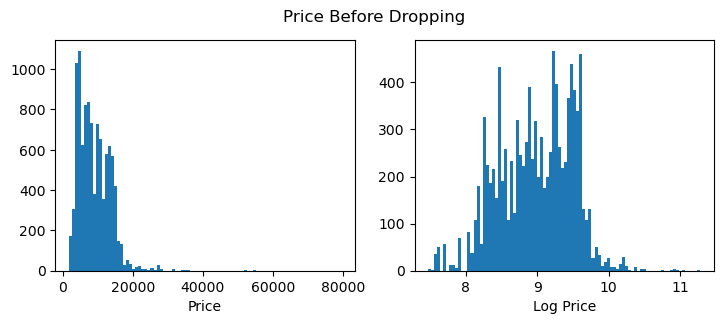

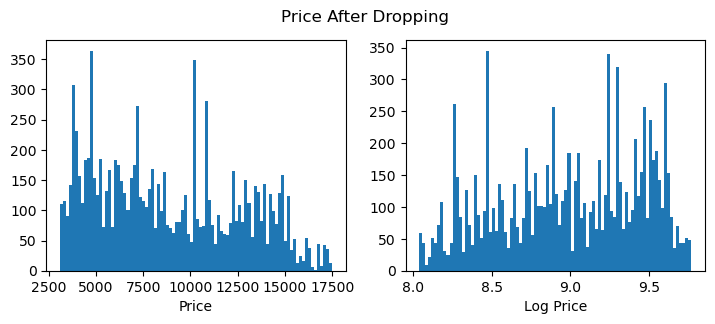

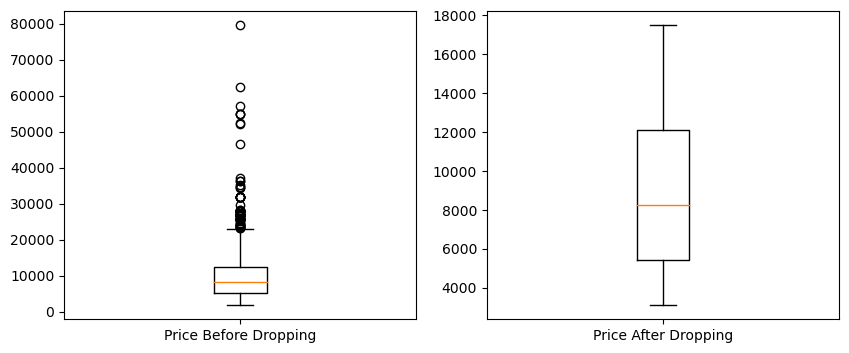

Airline
Jet Airways                          3517
IndiGo                               1947
Air India                            1640
Multiple carriers                    1159
SpiceJet                              702
Vistara                               474
Air Asia                              319
GoAir                                 191
Multiple carriers Premium economy      13
Vistara Premium economy                 3
Trujet                                  1
Name: count, dtype: int64


In [4]:
fig, axs = plt.subplots(1, 2, figsize=(8.5, 3))
axs[0].hist(plane['Price'], bins=90); axs[0].set_xlabel('Price')
axs[1].hist(np.log(plane['Price']), bins=90); axs[1].set_xlabel('Log Price')
fig.suptitle('Price Before Dropping')
plt.show()

plane['tmp'] = np.log(plane['Price'])
plane1 = plane.drop(plane[(plane['tmp'] <= 8) | (plane['tmp'] >= 9.77)].index, axis=0) #log가 8 이하, 9.77 이상인 경우 드랍
plane.drop('tmp', axis=1, inplace=True)

fig, axs = plt.subplots(1, 2, figsize=(8.5, 3))
axs[0].hist(plane1['Price'], bins=90); axs[0].set_xlabel('Price')
axs[1].hist(plane1['tmp'], bins=90); axs[1].set_xlabel('Log Price')
fig.suptitle('Price After Dropping')
plt.show()
plane1.drop('tmp', axis=1, inplace=True)
plane1.reset_index(drop=True, inplace=True)

fig, axs = plt.subplots(1,2,figsize=(10, 4))
axs[0].boxplot(plane['Price'], labels=['Price Before Dropping'])
axs[1].boxplot(plane1['Price'], labels=['Price After Dropping'])
plt.show()

print(plane1['Airline'].value_counts())
plane1.drop(plane1[plane1['Airline'].isin(['Multiple carriers Premium economy', 'Jet Airways Business', 'Vistara Premium economy', 'Trujet'])].index, inplace=True)

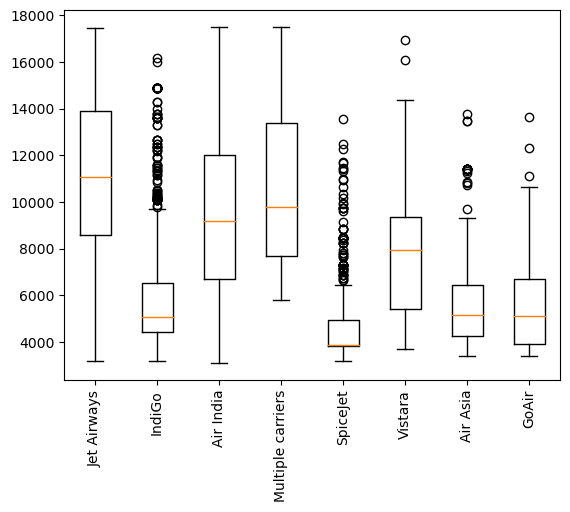

Jet Airways: 0
IndiGo: 103
Air India: 0
Multiple carriers: 0
SpiceJet: 71
Vistara: 2
Air Asia: 18
GoAir: 3
To Drop: 197


In [5]:
airlines_list = plane1['Airline'].value_counts().index
airlines_price = []
for x in airlines_list:
    airlines_price.append(plane1[plane1['Airline']==x]['Price'])

plt.boxplot(airlines_price, labels=airlines_list)
plt.xticks(rotation=90)
plt.show()

for i in range(len(airlines_list)):
    Q1 = airlines_price[i].quantile(q=0.25)
    Q2 = airlines_price[i].quantile(q=0.75)
    iqr=Q2-Q1
    lower = Q1-1.5*iqr
    upper = Q2+1.5*iqr
    lower_outlier = plane1[(plane1['Price'] > lower) & (plane1['Airline']==airlines_list[i])]['Price'].min()
    upper_outlier = plane1[(plane1['Price'] < upper) & (plane1['Airline']==airlines_list[i])]['Price'].max()
    price_outlier = plane1[(plane1['Price'] > upper_outlier) & (plane1['Airline']==airlines_list[i])]
    res = price_outlier['Airline'].value_counts()
    if(res.shape[0] > 0):
        print(airlines_list[i] + ': ' + str(res[0]))
    else:
        print(airlines_list[i] + ': 0')
    for i in price_outlier.index:
        plane1.loc[i, 'Airline'] = np.NaN

print('To Drop: ' + str(plane1['Airline'].isna().sum()))
plane1.dropna(inplace=True)
plane1.reset_index(drop=True, inplace=True)

<h3>Airline 전처리</h3>

In [6]:
airlines_df = pd.get_dummies(plane1['Airline'], prefix='Airline')
plane1 = pd.concat([plane1, airlines_df], axis=1)
plane1.drop('Airline',axis=1, inplace=True)
print(plane1['Source'].value_counts())
print()
print(plane1['Destination'].value_counts())

Source
Delhi       4129
Kolkata     2809
Banglore    2019
Mumbai       423
Chennai      372
Name: count, dtype: int64

Destination
Cochin       4129
Banglore     2809
Delhi        1264
New Delhi     755
Hyderabad     423
Kolkata       372
Name: count, dtype: int64


<h3>Route 전처리</h3>

In [7]:
#출발지와 목적지가 Route상과 다른 경우 확인 <- 데이터 오류 검증

rts=[]
def collectRt(X):
    global rts
    rts.extend(X)
    return X

res = plane1['Route'].apply(lambda x: x.upper().replace(' ', '').split('→')).apply(lambda x: x if len(x) <= 2 else [x[0], x[-1]])
source_check = pd.DataFrame(list(plane1['Source'] + '_' + res.apply(lambda x:x[0])))
print(source_check.value_counts()); print()
dst_check = pd.DataFrame(list(plane1['Destination'] + '_' + res.apply(lambda x:x[1])))
print(dst_check.value_counts()); print()
res = res.apply(collectRt).apply(lambda x: x[0] + '→'+x[1])
print(res.value_counts())

plane1.drop(['Source', 'Destination', 'Route'], axis=1, inplace=True)
rt_df = pd.get_dummies(res)
plane1 = pd.concat([plane1, rt_df], axis=1)

Delhi_DEL       4129
Kolkata_CCU     2809
Banglore_BLR    2019
Mumbai_BOM       423
Chennai_MAA      372
Name: count, dtype: int64

Cochin_COK       4129
Banglore_BLR     2809
Delhi_DEL        1264
New Delhi_DEL     755
Hyderabad_HYD     423
Kolkata_CCU       372
Name: count, dtype: int64

Route
DEL→COK    4129
CCU→BLR    2809
BLR→DEL    2019
BOM→HYD     423
MAA→CCU     372
Name: count, dtype: int64


<h3>Total_Stops 매핑</h3>

In [8]:
plane1.drop(plane1[plane1['Total_Stops'].isin(['4 stops'])].index, inplace=True)
plane1['Total_Stops'] = plane1['Total_Stops'].map({'non-stop':0, '1 stop': 1, '2 stops': 2, '3 stops': 3})

<h3>Dep_Time, Arrival_Time, Duration 숫자로 변환</h3>

In [9]:
def TimeToNum(x, h_, m_):
    h_t, m_t = [h_, m_]
    h, m = map(int, x.split(':'))
    if h >= h_t:
        h = h - h_t
    else:
        h = 24 - (h_t - h)
    if m >= m_t:
        m = m - m_t
    else:
        m = 60 - (m_t - m)
    
    return h*3600 + m*60
    
plane1['Dep_Time'] =np.log1p(plane1['Dep_Time'].apply(TimeToNum, args=(0, 0)))

In [10]:
times = plane1['Arrival_Time'].apply(lambda X: X.split(' ')[0] if len(X) > 5 else X)
plane1['Arrival_Time'] = np.log1p(times.apply(TimeToNum, args=(0, 0)))

In [11]:
print(plane1['Duration'].shape[0])
tmp = plane1['Duration'].apply(lambda x: 'h' in x)
print(tmp[tmp==True].shape[0])
print(plane1['Duration'].iloc[tmp[tmp==False].index])
tmp = plane1['Duration'].apply(lambda x: 'm' in x)
print(tmp[tmp==True].shape[0])
print(plane1['Duration'].iloc[tmp[tmp==False].index])

tmp = plane1['Duration'].apply(lambda x: ('h' in x) or ('m' in x)) #h 혹은 m이 없는 경우 확인
print(tmp[tmp==False].shape[0])

def du(X):
    X = X.replace(' ', '')
    hAndm = X.split('h')
    if len(hAndm) == 1:
        minutes = hAndm[0].split('m')[0]
        hours = 0
    else:
        hours = hAndm[0]
        if hAndm[1] == '':
            minutes = 0
        else:
            minutes = hAndm[1].split('m')[0] 
    hours, minutes = int(hours), int(minutes)
    return hours*60 + minutes

plane1['Duration'] = np.log1p(plane1['Duration'].apply(du))

9752
9751
5956    5m
Name: Duration, dtype: object
8778
2       19h
16      23h
30      22h
40      12h
49       3h
       ... 
9654    20h
9670    23h
9710    14h
9711    38h
9749     3h
Name: Duration, Length: 974, dtype: object
0


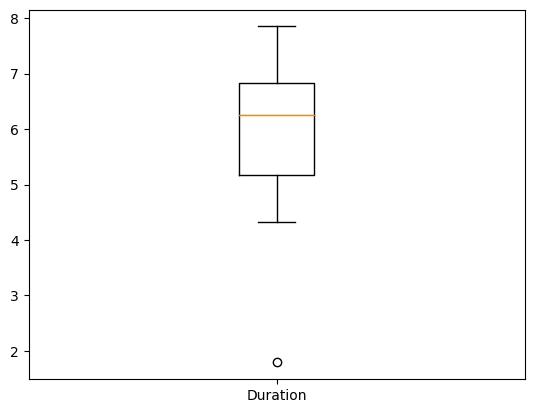

In [12]:
#Duration Outlier
plt.boxplot(plane1['Duration'], labels=['Duration'])
plane1.drop(plane1[plane1['Duration'] < 3].index, axis=0, inplace=True)

<h3>Additional_Info 전처리</h3>

In [13]:
plane1['Additional_Info'] = plane1['Additional_Info'].apply(str.lower)
print(plane1['Additional_Info'].value_counts())
plane1.drop(plane1[plane1['Additional_Info'].isin(['1 short layover', 'business class', 'red-eye flight', '2 long layover', '1 long layover', 'change airports'])].index, axis=0, inplace=True)
print()
print(plane1['Additional_Info'].value_counts())

#Additional_Info
encoder = OneHotEncoder(sparse_output=False)
addinfo_ohc = encoder.fit_transform(plane1[['Additional_Info']])
addinfo_ohc_df = pd.DataFrame(addinfo_ohc, columns= encoder.categories_[0])
plane1.reset_index(drop=True, inplace=True)
plane1 = pd.concat([plane1, addinfo_ohc_df], axis=1)
plane1.drop(['Additional_Info', 'no info'], axis=1, inplace=True)
plane1

Additional_Info
no info                         7578
in-flight meal not included     1898
no check-in baggage included     264
1 long layover                     6
change airports                    5
Name: count, dtype: int64

Additional_Info
no info                         7578
in-flight meal not included     1898
no check-in baggage included     264
Name: count, dtype: int64


Date_of_Journey   Dep_Time  Arrival_Time  Duration  Total_Stops  Price  \
0         24/03/2019  11.294782      8.343078  5.141664            0   3897   
1          1/05/2019   9.952325     10.772708  6.100319            2   7662   
2          9/06/2019  10.431200      9.674137  7.039660            2  13882   
3         12/05/2019  11.083695     11.345701  5.786897            1   6218   
4         24/06/2019  10.385945     10.623788  4.983607            0   3873   
...              ...        ...           ...       ...          ...    ...   
9735       9/04/2019  11.180260     11.298506  5.017280            0   4107   
9736      27/04/2019  11.221249     11.338584  5.049856            0   4145   
9737      27/04/2019  10.308986     10.616462  5.198497            0   7229   
9738      01/03/2019  10.631060     10.839601  5.081404            0  12648   
9739       9/05/2019  10.579005     11.146215  6.216606            2  11753   

      Airline_Air Asia  Airline_Air India  Airline_GoAir  Airline_IndiGo  \
0                False              False          False            True   
1                False               True          False           False   
2                False              False          False           False   
3                False              False          False            True   
4                False              False          False           False   
...                ...                ...            ...             ...   
9735              True              False          False           False   
9736             False               True          False           False   
9737             False              False          False           False   
9738             False              False          False           False   
9739             False               True          False           False   

      Airline_Jet Airways  Airline_Multiple carriers  Airline_SpiceJet  \
0                   False                      False             False   
1                   False                      False             False   
2                    True                      False             False   
3                   False                      False             False   
4                   False                      False              True   
...                   ...                        ...               ...   
9735                False                      False             False   
9736                False                      False             False   
9737                 True                      False             False   
9738                False                      False             False   
9739                False                      False             False   

      Airline_Vistara  BLR→DEL  BOM→HYD  CCU→BLR  DEL→COK  MAA→CCU  \
0               False     True    False    False    False    False   
1               False    False    False     True    False    False   
2               False    False    False    False     True    False   
3               False    False    False     True    False    False   
4               False    False    False     True    False    False   
...               ...      ...      ...      ...      ...      ...   
9735            False    False    False     True    False    False   
9736            False    False    False     True    False    False   
9737            False     True    False    False    False    False   
9738             True     True    False    False    False    False   
9739            False    False    False    False     True    False   

      in-flight meal not included  no check-in baggage included  
0                             0.0                           0.0  
1                             0.0                           0.0  
2                             0.0                           0.0  
3                             0.0                           0.0  
4                             0.0                           0.0  
...              

<h3>Additional_Info 전처리</h3>

In [14]:
print(plane1['Date_of_Journey'].apply(lambda x: x.split('/')[1]).value_counts())
plane1.drop('Date_of_Journey', axis=1, inplace=True) #모두 2019년, 달은 3~6월, 분기 차이 거의 없음, 드랍

Date_of_Journey
05    3272
06    3175
03    2242
04    1051
Name: count, dtype: int64


In [15]:
plane1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9740 entries, 0 to 9739
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Dep_Time                      9740 non-null   float64
 1   Arrival_Time                  9740 non-null   float64
 2   Duration                      9740 non-null   float64
 3   Total_Stops                   9740 non-null   int64  
 4   Price                         9740 non-null   int64  
 5   Airline_Air Asia              9740 non-null   bool   
 6   Airline_Air India             9740 non-null   bool   
 7   Airline_GoAir                 9740 non-null   bool   
 8   Airline_IndiGo                9740 non-null   bool   
 9   Airline_Jet Airways           9740 non-null   bool   
 10  Airline_Multiple carriers     9740 non-null   bool   
 11  Airline_SpiceJet              9740 non-null   bool   
 12  Airline_Vistara               9740 non-null   bool   
 13  BLR

In [16]:
plane1.reset_index(drop=True, inplace=True)
plane1

Dep_Time  Arrival_Time  Duration  Total_Stops  Price  Airline_Air Asia  \
0     11.294782      8.343078  5.141664            0   3897             False   
1      9.952325     10.772708  6.100319            2   7662             False   
2     10.431200      9.674137  7.039660            2  13882             False   
3     11.083695     11.345701  5.786897            1   6218             False   
4     10.385945     10.623788  4.983607            0   3873             False   
...         ...           ...       ...          ...    ...               ...   
9735  11.180260     11.298506  5.017280            0   4107              True   
9736  11.221249     11.338584  5.049856            0   4145             False   
9737  10.308986     10.616462  5.198497            0   7229             False   
9738  10.631060     10.839601  5.081404            0  12648             False   
9739  10.579005     11.146215  6.216606            2  11753             False   

      Airline_Air India  Airline_GoAir  Airline_IndiGo  Airline_Jet Airways  \
0                 False          False            True                False   
1                  True          False           False                False   
2                 False          False           False                 True   
3                 False          False            True                False   
4                 False          False           False                False   
...                 ...            ...             ...                  ...   
9735              False          False           False                False   
9736               True          False           False                False   
9737              False          False           False                 True   
9738              False          False           False                False   
9739               True          False           False                False   

      Airline_Multiple carriers  Airline_SpiceJet  Airline_Vistara  BLR→DEL  \
0                         False             False            False     True   
1                         False             False            False    False   
2                         False             False            False    False   
3                         False             False            False    False   
4                         False              True            False    False   
...                         ...               ...              ...      ...   
9735                      False             False            False    False   
9736                      False             False            False    False   
9737                      False             False            False     True   
9738                      False             False             True     True   
9739                      False             False            False    False   

      BOM→HYD  CCU→BLR  DEL→COK  MAA→CCU  in-flight meal not included  \
0       False    False    False    False                          0.0   
1       False     True    False    False                          0.0   
2       False    False     True    False                          0.0   
3       False     True    False    False                          0.0   
4       False     True    False    False                          0.0   
...       ...      ...      ...      ...                          ...   
9735    False     True    False    False                          0.0   
9736    False     True    False    False                          0.0   
9737    False    False    False    False                          0.0   
9738    False    False    False    False                          0.0   
9739    False    False     True    False                          0.0   

      no check-in baggage included  
0                              0.0  
1                              0.0  
2                              0.0  
3                              0.0  
4                              0.0  
...                            ...  


<h3>Corr() 행렬</h3>

<Axes: >

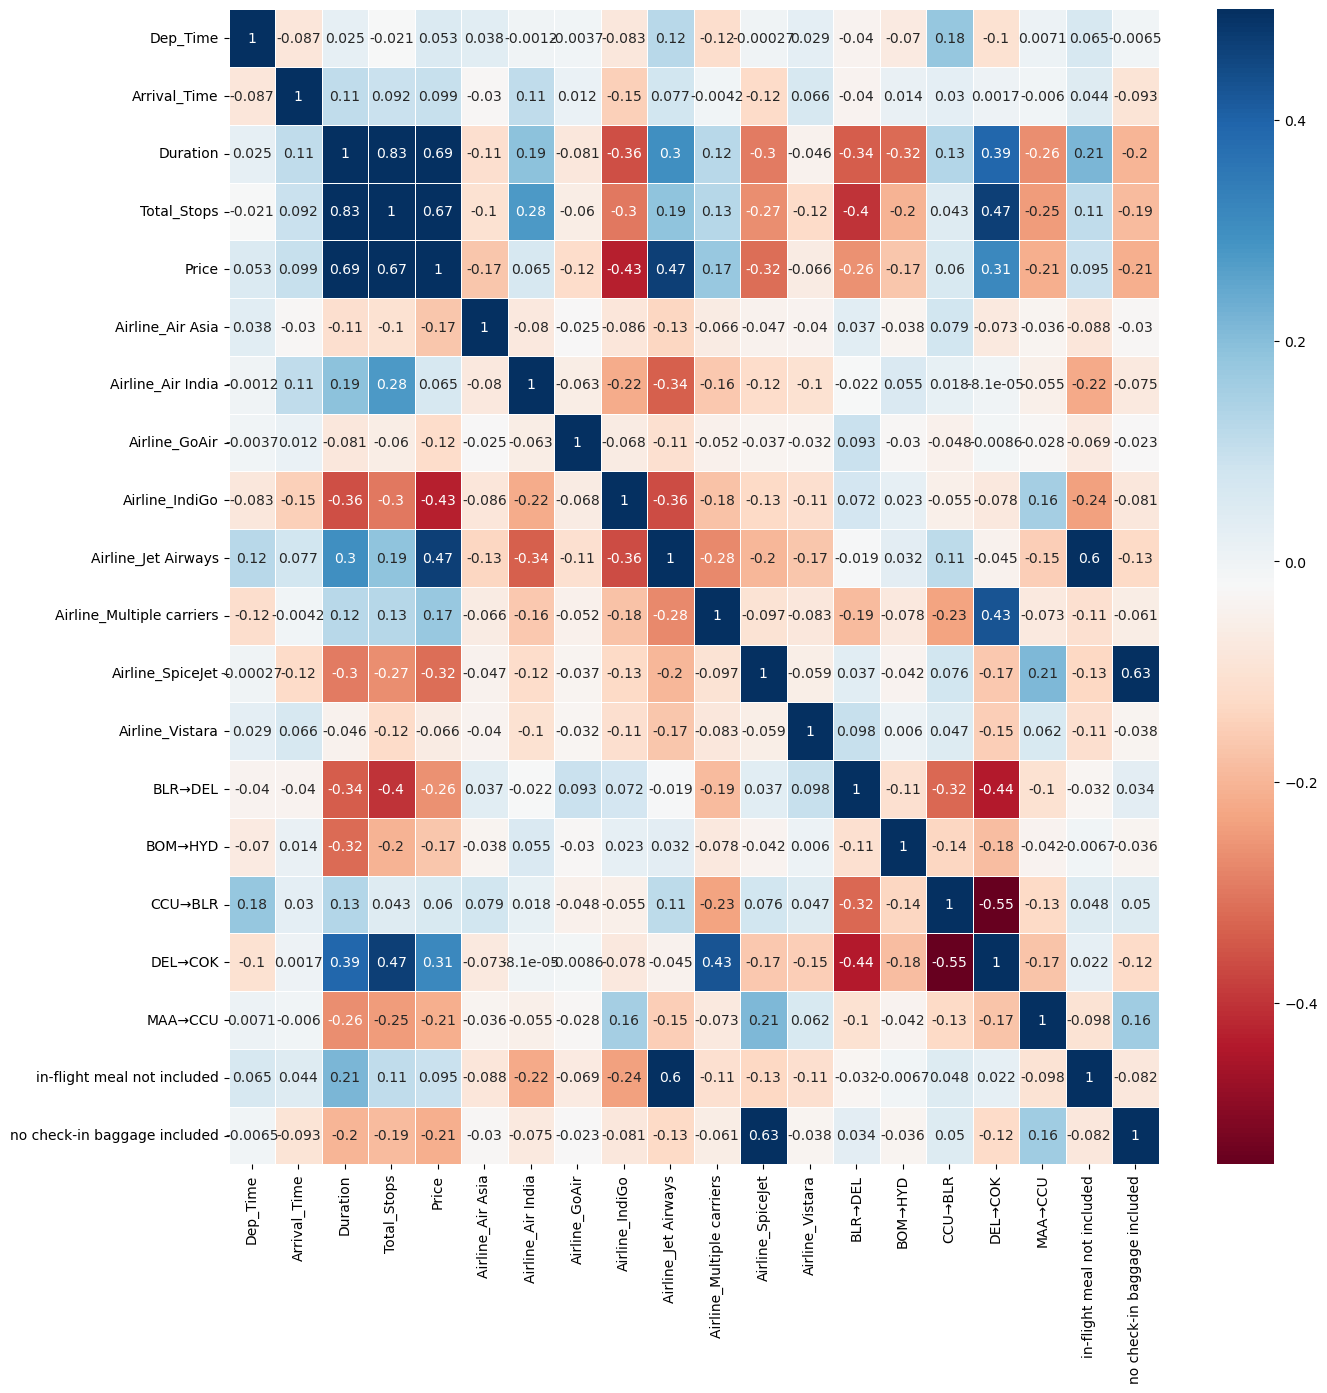

In [17]:
import seaborn as sb

plt.figure(figsize=(15,15))
sb.heatmap(plane1.corr(), cmap='RdBu', linewidth=0.5, vmax=0.5, annot=True)

In [18]:
plane1.drop(['CCU→BLR', 'Airline_Vistara', 'Airline_Air India', 'Arrival_Time',  'Dep_Time'], axis=1, inplace=True)
plane1['Price'] = np.log1p(plane1['Price'])
plane1

Duration  Total_Stops     Price  Airline_Air Asia  Airline_GoAir  \
0     5.141664            0  8.268219             False          False   
1     6.100319            2  8.944159             False          False   
2     7.039660            2  9.538420             False          False   
3     5.786897            1  8.735364             False          False   
4     4.983607            0  8.262043             False          False   
...        ...          ...       ...               ...            ...   
9735  5.017280            0  8.320692              True          False   
9736  5.049856            0  8.329899             False          False   
9737  5.198497            0  8.885994             False          False   
9738  5.081404            0  9.445333             False          False   
9739  6.216606            2  9.371949             False          False   

      Airline_IndiGo  Airline_Jet Airways  Airline_Multiple carriers  \
0               True                False                      False   
1              False                False                      False   
2              False                 True                      False   
3               True                False                      False   
4              False                False                      False   
...              ...                  ...                        ...   
9735           False                False                      False   
9736           False                False                      False   
9737           False                 True                      False   
9738           False                False                      False   
9739           False                False                      False   

      Airline_SpiceJet  BLR→DEL  BOM→HYD  DEL→COK  MAA→CCU  \
0                False     True    False    False    False   
1                False    False    False    False    False   
2                False    False    False     True    False   
3                False    False    False    False    False   
4                 True    False    False    False    False   
...                ...      ...      ...      ...      ...   
9735             False    False    False    False    False   
9736             False    False    False    False    False   
9737             False     True    False    False    False   
9738             False     True    False    False    False   
9739             False    False    False     True    False   

      in-flight meal not included  no check-in baggage included  
0                             0.0                           0.0  
1                             0.0                           0.0  
2                             0.0                           0.0  
3                             0.0                           0.0  
4                             0.0                           0.0  
...                           ...                           ...  
9735                          0.0                           0.0  
9736                          0.0                           0.0  
9737                          0.0                           0.0  
9738                          0.0                           0.0  
9739                          0.0                           0.0  

[9740 rows x 15 columns]

In [19]:
plane1.describe()

Duration  Total_Stops        Price  in-flight meal not included  \
count  9740.000000  9740.000000  9740.000000                  9740.000000   
mean      6.117516     0.808830     8.978498                     0.194867   
std       0.884258     0.657485     0.459351                     0.396118   
min       4.330733     0.000000     8.039480                     0.000000   
25%       5.170484     0.000000     8.571303                     0.000000   
50%       6.255750     1.000000     8.996404                     0.000000   
75%       6.832220     1.000000     9.395616                     0.000000   
max       7.850104     3.000000     9.769613                     1.000000   

       no check-in baggage included  
count                   9740.000000  
mean                       0.027105  
std                        0.162397  
min                        0.000000  
25%                        0.000000  
50%                        0.000000  
75%                        0.000000  
max                        1.000000

<Axes: >

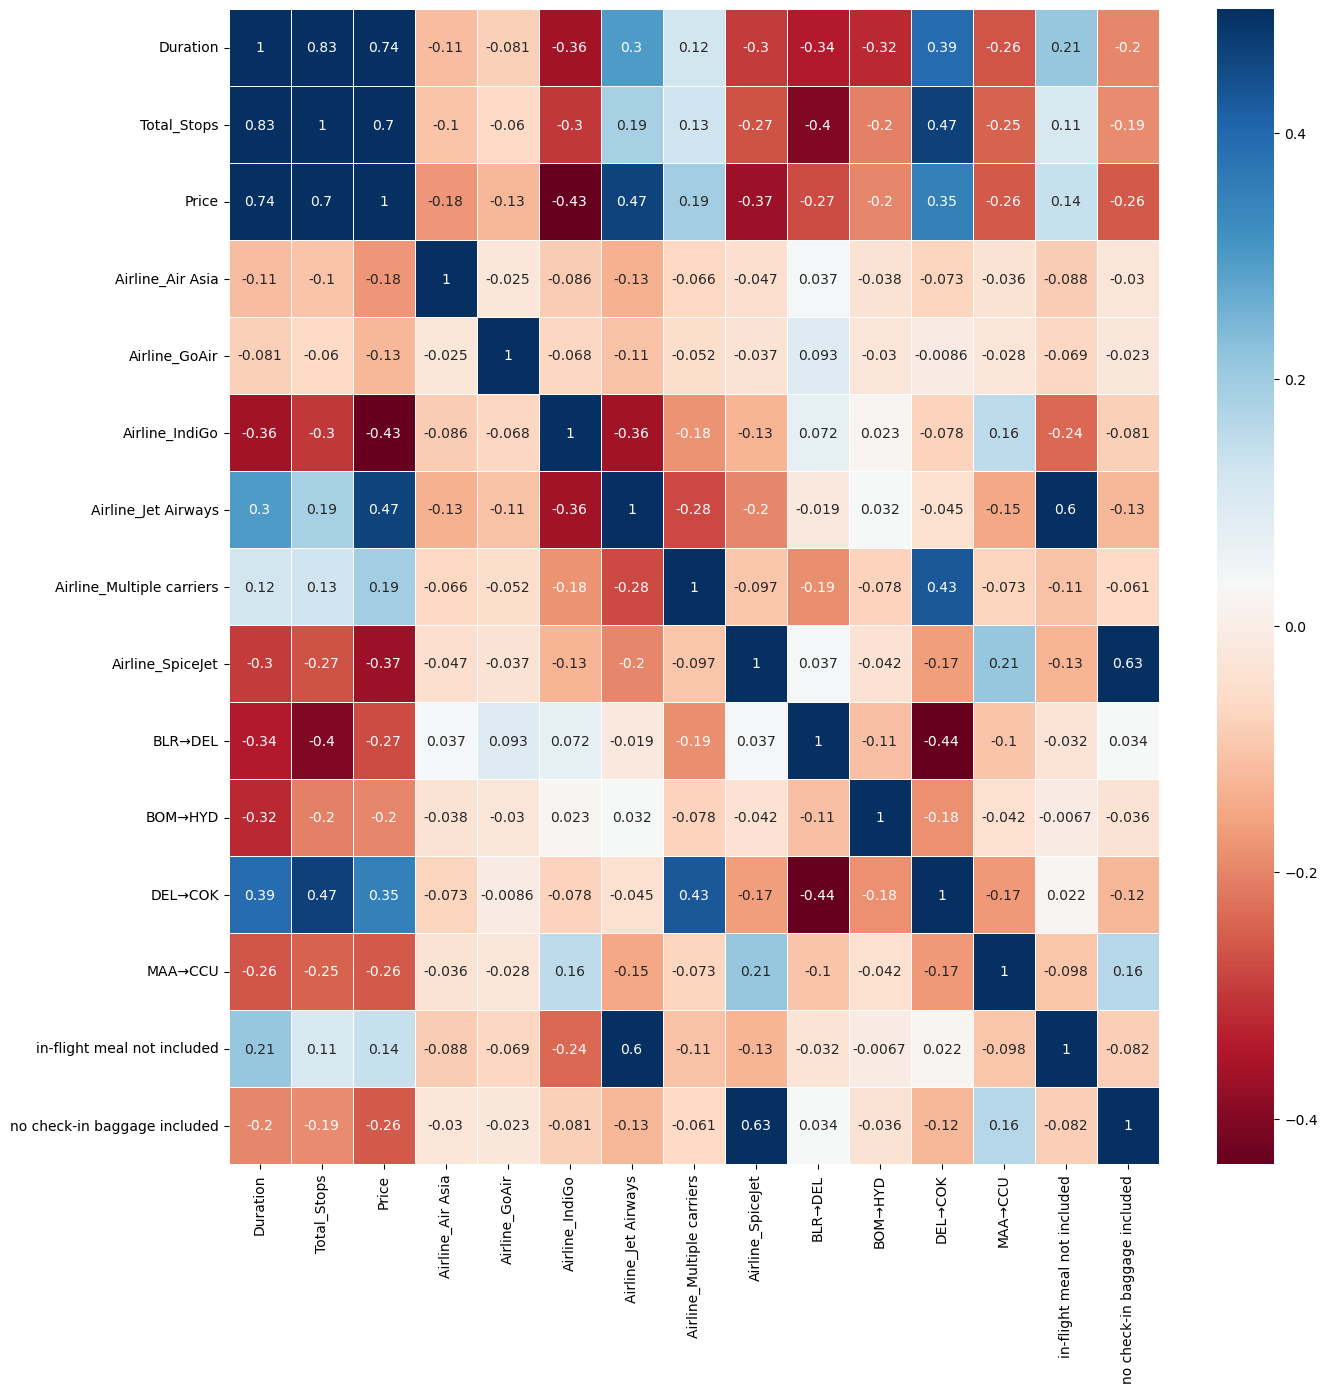

In [20]:
import seaborn as sb

plt.figure(figsize=(15,15))
sb.heatmap(plane1.corr(), cmap='RdBu', linewidth=0.5, vmax=0.5, annot=True)

In [21]:
#--------------------------------

<h3>학습 및 파라미터 튜닝</h3>

<h3>train, test 분리 및 정규화</h3>

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler, MinMaxScaler

X, y = plane1.drop('Price', axis=1), plane1['Price']

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

#데이터 분할 후 정규화 적용
sc = MinMaxScaler()
to_minmax = plane1.columns.difference(['Price']).tolist()
X_train[to_minmax] = sc.fit_transform(X_train[to_minmax])
X_test[to_minmax] = sc.transform(X_test[to_minmax])

Poly_X_train = pd.DataFrame(PolynomialFeatures(degree=2, include_bias=False).fit_transform(X_train))
Poly_X_test = pd.DataFrame(PolynomialFeatures(degree=2, include_bias=False).fit_transform(X_test))

In [23]:
print('data size:', X.shape[0])
print('train size:', X_train.shape[0])
print('test size:', X_test.shape[0])

data size: 9740
train size: 7792
test size: 1948


In [24]:
def show_result(model, X, y, percent=0.03, showline=False, suptitle=''):
    neg_mse_scores = cross_val_score(model, X[0], y[0], cv=5, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-1*neg_mse_scores)
    avg_rmse=np.mean(rmse_scores)
    print('RMSE:', rmse_scores, avg_rmse)
    r2_scores = cross_val_score(model, X[0], y[0], cv=5, scoring='r2')
    print('R2: ', r2_scores, np.mean(r2_scores))
    
    model.fit(X[0], y[0])

    print('--- Train ---')
    pred1 = model.predict(X[0])
    mse = mean_squared_error(y[0], pred1)
    rmse = np.sqrt(mse)
    r2 = r2_score(y[0], pred1)
    print(rmse, r2)

    print('--- Test ---')
    pred2 = model.predict(X[1])
    mse = mean_squared_error(y[1], pred2)
    rmse = np.sqrt(mse)
    r2 = r2_score(y[1], pred2)
    print(rmse, r2)

    n = X[0].shape[0]; k = round(n*percent);
    steps0 = n // k
    n = X[1].shape[0]; k = round(n*percent);
    steps1 = n // k
    
    for i, x in enumerate(X[0].columns[:1]):
        pred_list1 = list(zip(X[0].iloc[:, i], pred1))
        pred_list1.sort(key=lambda y:y[0])
        pred_list2 = list(zip(X[1].iloc[:,i], pred2))
        pred_list2.sort(key=lambda y:y[0])
        
        fig, axs = plt.subplots(1, 2, figsize=(10,4))
        axs[0].scatter(X[0].iloc[:, i], y[0], color='tab:blue', label='y', s=10)
        axs[0].scatter(X[0].iloc[:, i], pred1, color='r', label='y_pred', s=7)
        if showline:
            axs[0].plot([y[0] for y in pred_list1[0::steps0]], [y[1] for y in pred_list1[0::steps0]], color='r', linewidth=1.2)
        axs[0].set_xlabel(str(x) + '_train_plot')
        axs[0].legend(loc='lower right')
        
        axs[1].scatter(X[1].iloc[:, i], y[1], color='tab:blue', label='y', s=10)
        axs[1].scatter(X[1].iloc[:, i], pred2, color='r', label='y_pred', s=7)
        if showline:
            axs[1].plot([y[0] for y in pred_list2[0::steps1]], [y[1] for y in pred_list2[0::steps1]], color='r', linewidth=1.2)
        axs[1].set_xlabel(str(x) + '_test_plot')
        axs[1].legend(loc='lower right')
        fig.suptitle(suptitle)
        plt.show()
        
    z = np.polyfit(y[1], pred2, 1)
    p = np.poly1d(z)
    l = np.linspace(min(y[1]), max(y[1]), 300)
    plt.plot(l, p(l), "r")
    
    plt.scatter(y_test, pred2, s=1)

    xs = np.linspace(min(y[1]), max(y[1]), 300)
    ys = xs
    plt.plot(xs, ys, "g--")
    plt.title(suptitle.split(' ')[0] + ' slope: ' + str(z[0]))
    plt.xlabel('y')
    plt.ylabel('y_hat')

    plt.show()

In [25]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y, title='',step=30):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)
    train_errors, test_errors = [], []
    train_size = []
    for m in range(1, len(X_train) + 1, step):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_test_predict = model.predict(X_test)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        test_errors.append(mean_squared_error(y_test, y_test_predict))
        train_size.append(m)
        
    plt.plot(train_size, np.sqrt(train_errors), 'r-', linewidth=2, label='train')
    plt.plot(train_size, np.sqrt(test_errors), 'b-', linewidth=2, label='test')
    plt.legend(fontsize=14)
    plt.xlabel('Training set size', fontsize=14)
    plt.ylabel('RMSE', fontsize=14)
    plt.ylim([0, 0.5])
    plt.title(title)
    plt.show()

<h3>Linear Regression</h3>

RMSE: [0.22211111 0.21966484 0.22308855 0.21718398 0.22279936] 0.22096956876187607
R2:  [0.76531967 0.77121122 0.76452786 0.77103612 0.76502929] 0.7674248337521765
--- Train ---
0.22057864444983405 0.7684744745936162
--- Test ---
0.225000414751587 0.7637752445445838


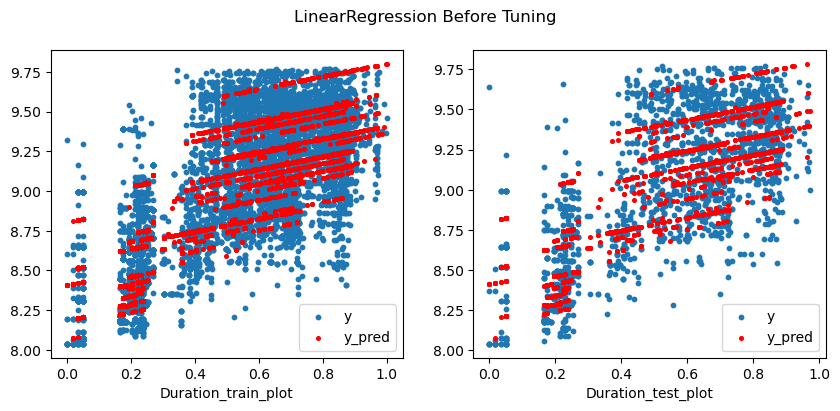

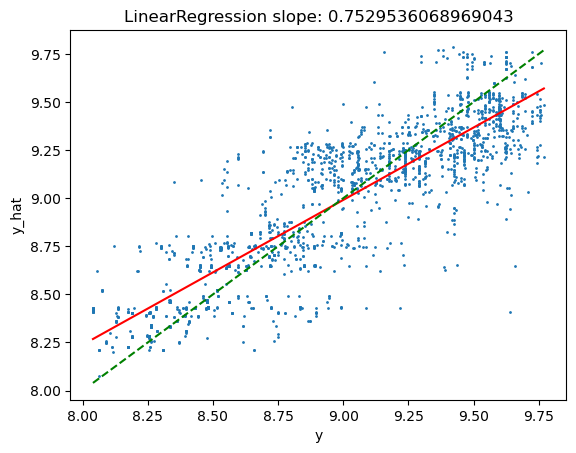

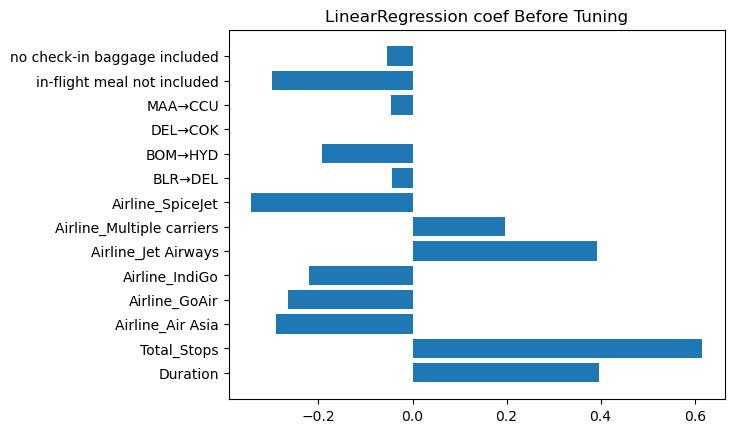

In [26]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
show_result(lr, [X_train, X_test], [y_train, y_test], suptitle='LinearRegression Before Tuning')
lr.fit(X_train, y_train)
plt.barh(X_train.columns, lr.coef_)
plt.title('LinearRegression coef Before Tuning')
plt.show()

RMSE: [0.20277147 0.20376242 0.20537525 0.2004097  0.20761311] 0.20398639094712392
R2:  [0.80440858 0.80313803 0.80043646 0.80503849 0.79596937] 0.8017981860909146
--- Train ---
0.2016062358082074 0.8065895775788438
--- Test ---
0.2091130385466014 0.7959573308537012


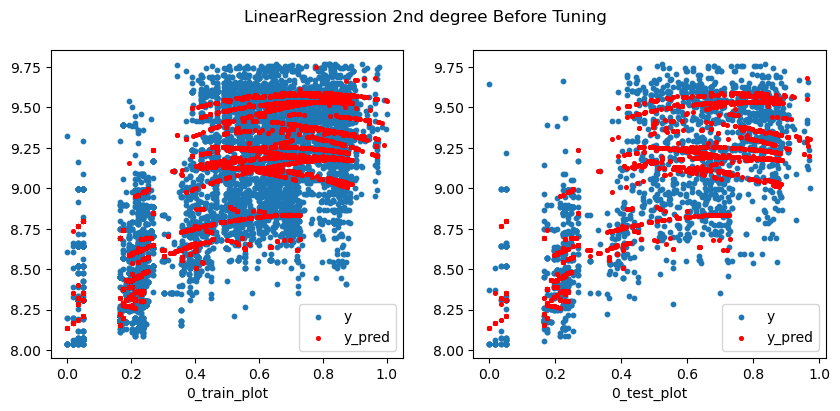

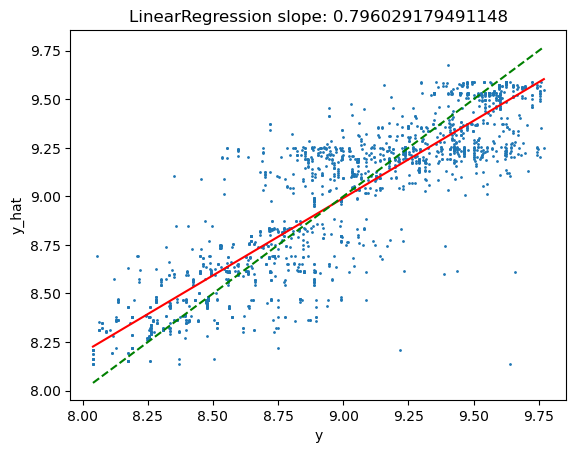

In [27]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
show_result(lr, [Poly_X_train, Poly_X_test], [y_train, y_test], suptitle='LinearRegression 2nd degree Before Tuning')
plt.show()

<h3>LinearRegression 튜닝</h3>

In [28]:
from sklearn.model_selection import GridSearchCV
lr = LinearRegression()
lr_param_grid = {'fit_intercept':[True, False],
                 'positive':[True,False]}
lr_grid_search = GridSearchCV(lr, param_grid=lr_param_grid, cv=5, scoring='neg_mean_squared_error')
lr_grid_search.fit(Poly_X_train, y_train)
print("LinearRegression best params: ", lr_grid_search.best_params_)

LinearRegression best params:  {'fit_intercept': True, 'positive': False}


<h3>LinearRegression 튜닝 결과</h3>

RMSE: [0.20277147 0.20376242 0.20537525 0.2004097  0.20761311] 0.20398639094712392
R2:  [0.80440858 0.80313803 0.80043646 0.80503849 0.79596937] 0.8017981860909146
--- Train ---
0.2016062358082074 0.8065895775788438
--- Test ---
0.2091130385466014 0.7959573308537012


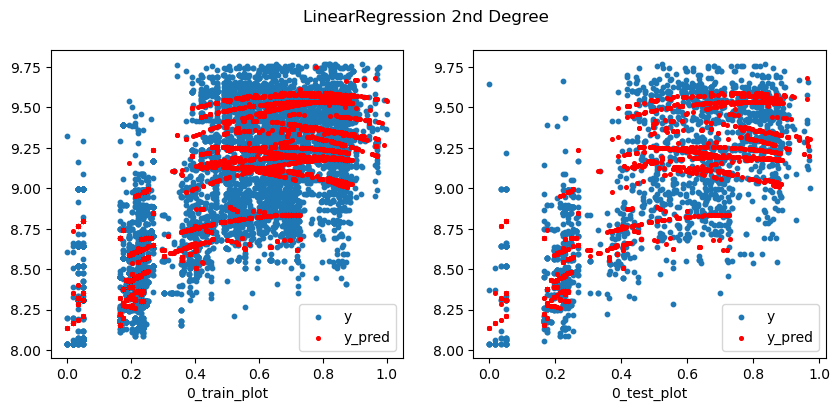

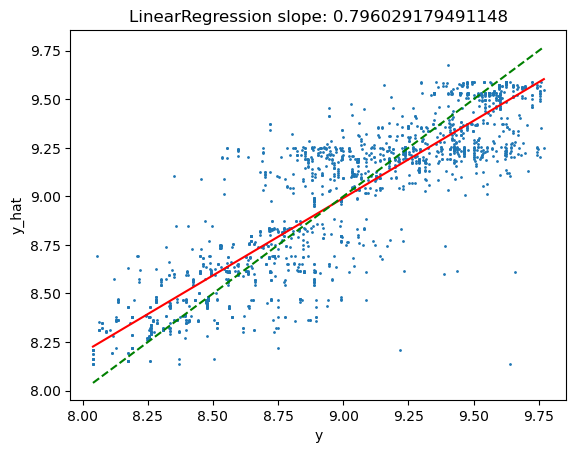

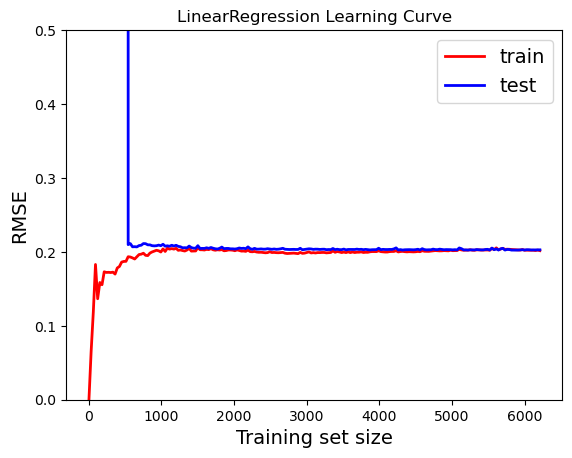

In [29]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression(fit_intercept=True, positive=False)
show_result(lr, [Poly_X_train, Poly_X_test], [y_train, y_test], suptitle='LinearRegression 2nd Degree')
plot_learning_curves(lr, Poly_X_train, y_train, 'LinearRegression Learning Curve')

<h3>Ridge, Lasso</h3>

RMSE: [0.22210212 0.21965115 0.22308806 0.21718773 0.22281529] 0.2209688694904129
R2:  [0.76533868 0.77123974 0.76452889 0.77102822 0.76499569] 0.7674262443052858
--- Train ---
0.22057954583660194 0.7684725823481364
--- Test ---
0.22501895548411407 0.7637363116344756


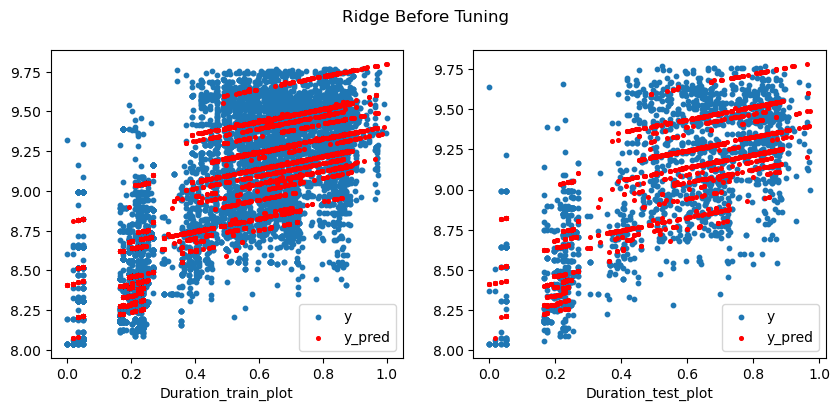

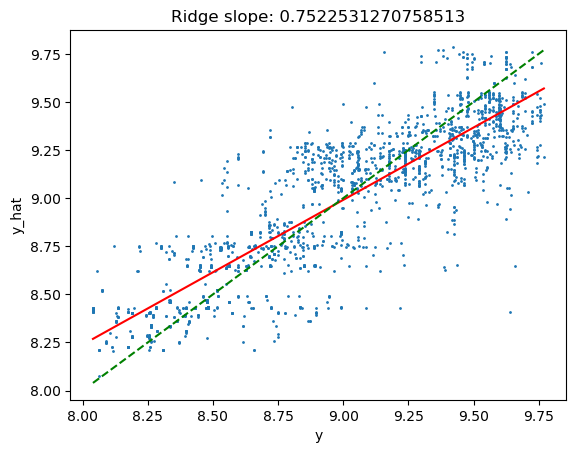

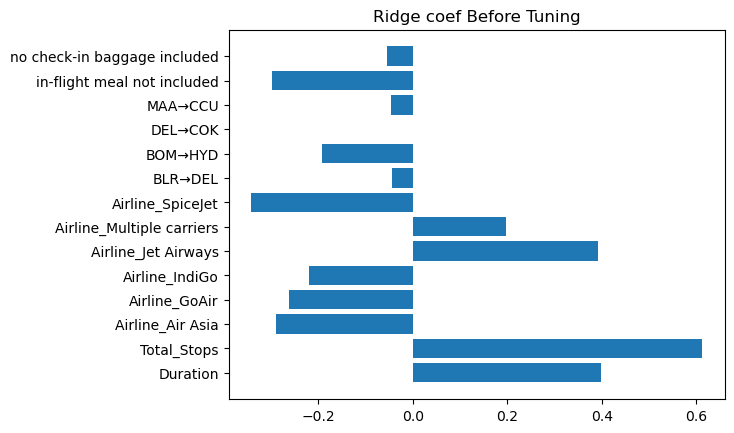

RMSE: [0.45900693 0.45926886 0.4604333  0.45413761 0.45984146] 0.45853763315185114
R2:  [-0.00224659 -0.00010969 -0.0030404  -0.00112049 -0.00092625] -0.001488684700272369
--- Train ---
0.4584204933988277 0.0
--- Test ---
0.4629356722669712 -1.5067136671653714e-07


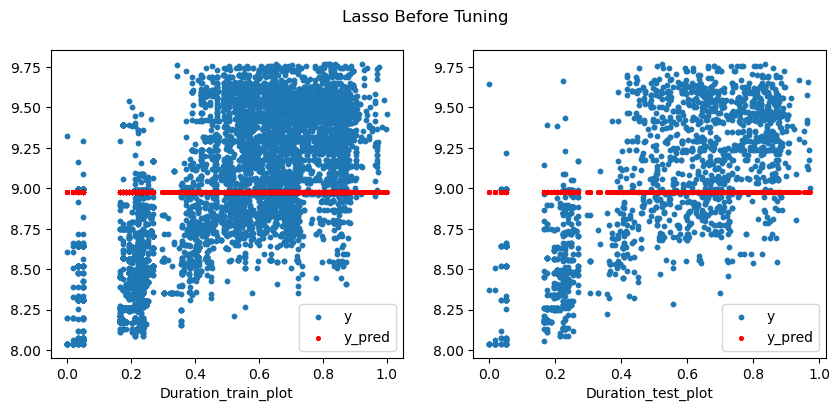

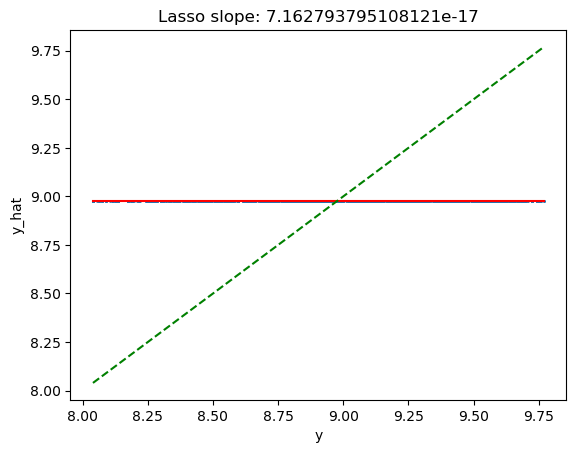

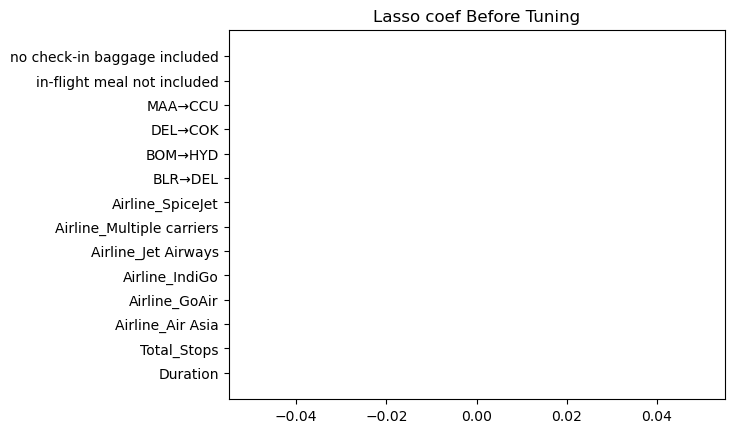

RMSE: [0.20308271 0.20405932 0.20591261 0.20147114 0.20728796] 0.2043627454629861
R2:  [0.80380768 0.80256393 0.7993908  0.80296785 0.79660795] 0.8010676446250524
--- Train ---
0.20238094404403936 0.8051002929475242
--- Test ---
0.2096529400049124 0.7949023497940562


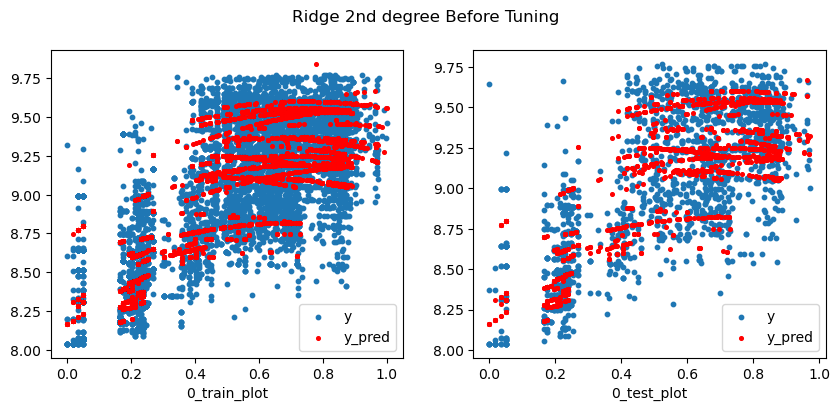

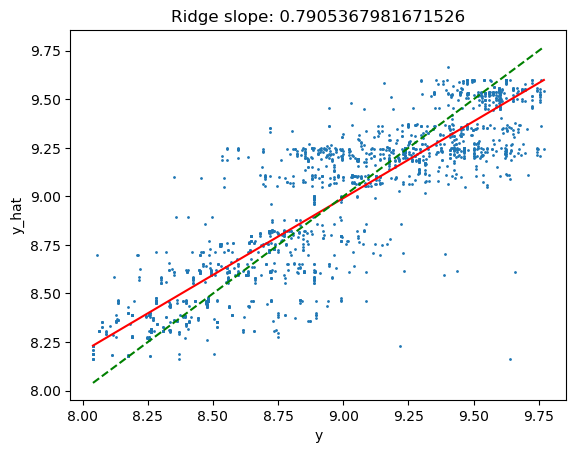

RMSE: [0.45900693 0.45926886 0.4604333  0.45413761 0.45984146] 0.45853763315185114
R2:  [-0.00224659 -0.00010969 -0.0030404  -0.00112049 -0.00092625] -0.001488684700272369
--- Train ---
0.4584204933988277 0.0
--- Test ---
0.4629356722669712 -1.5067136671653714e-07


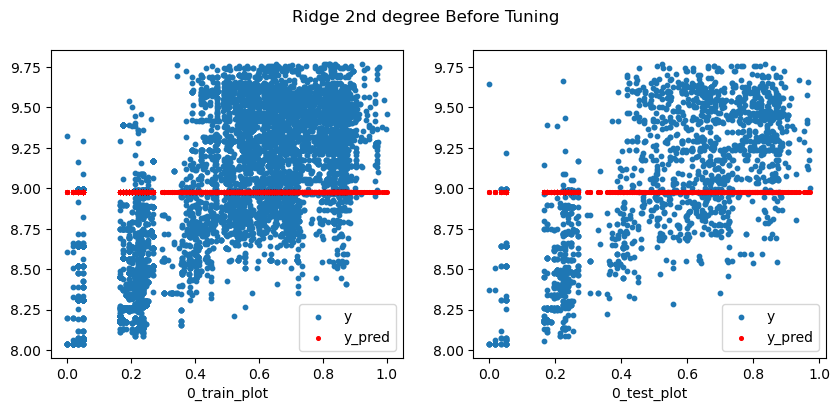

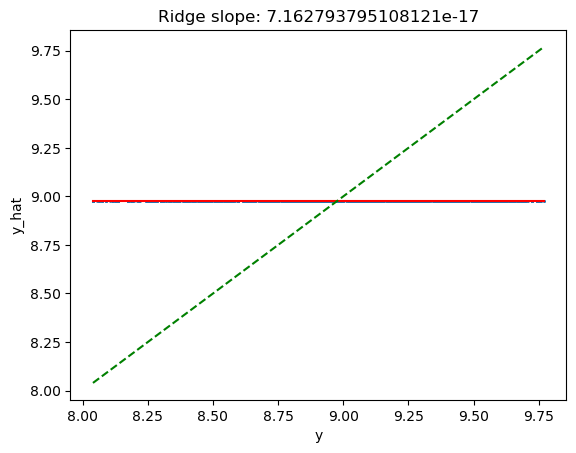

In [32]:
from sklearn.linear_model import Ridge, Lasso

ridge = Ridge()
show_result(ridge, [X_train, X_test], [y_train, y_test], suptitle='Ridge Before Tuning')
ridge.fit(X_train, y_train)
plt.barh(X_train.columns, ridge.coef_)
plt.title('Ridge coef Before Tuning')
plt.show()

lasso = Lasso()
show_result(lasso, [X_train, X_test], [y_train, y_test], suptitle='Lasso Before Tuning')
lasso.fit(X_train, y_train)
plt.barh(X_train.columns, lasso.coef_)
plt.title('Lasso coef Before Tuning')
plt.show()

show_result(ridge, [Poly_X_train, Poly_X_test], [y_train, y_test], suptitle='Ridge 2nd degree Before Tuning')
show_result(lasso, [Poly_X_train, Poly_X_test], [y_train, y_test], suptitle='Lasso 2nd degree Before Tuning')

<h3>Ridge, Lasso 튜닝</h3>

In [33]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV

ridge = Ridge()
ridge_param_grid = {'alpha': [0, 0.05, 0.1, 1, 5, 10, 100],
                   'fit_intercept':[True, False]}
ridge_grid_search = GridSearchCV(ridge, param_grid=ridge_param_grid, cv=5, scoring='neg_mean_squared_error')
ridge_grid_search.fit(Poly_X_train, y_train)


lasso = Lasso()
lasso_param_grid = {'alpha': [0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.02, 0.05, 0.07, 0.1, 0.5, 1, 3],
                    'fit_intercept':[True, False]}
lasso_grid_search = GridSearchCV(lasso, param_grid=lasso_param_grid, cv=5, scoring='neg_mean_squared_error')
lasso_grid_search.fit(Poly_X_train, y_train)


print("Ridge best params: ", ridge_grid_search.best_params_)
print("Lasso best params: ", lasso_grid_search.best_params_)

Ridge best params:  {'alpha': 0.05, 'fit_intercept': True}
Lasso best params:  {'alpha': 1e-06, 'fit_intercept': True}


<h3>Ridge, Lasso 튜닝 결과</h3>

RMSE: [0.20211671 0.20373943 0.2056316  0.20015311 0.20742242] 0.2038126551758916
R2:  [0.80566968 0.80318245 0.79993796 0.8055374  0.796344  ] 0.8021342987475059
--- Train ---
0.20169985402593862 0.8064099110818893
--- Test ---
0.20910164996621122 0.7959795551308604


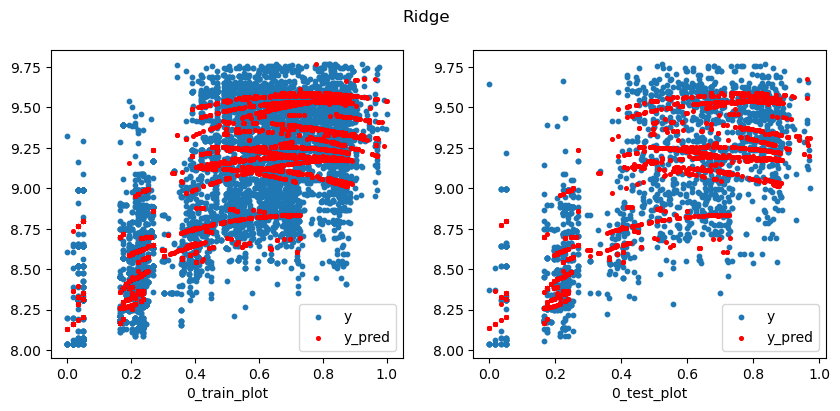

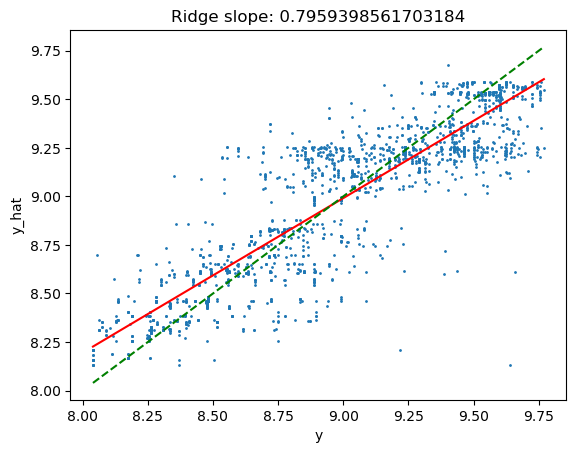

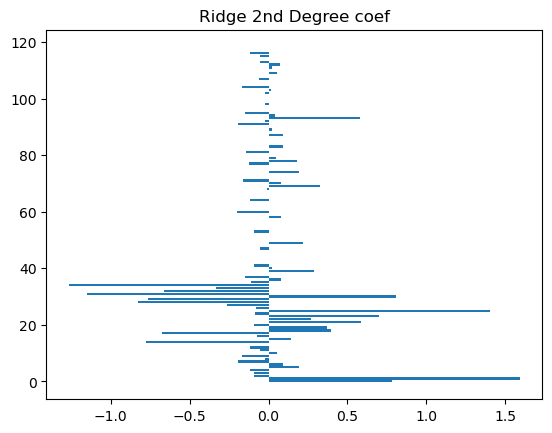

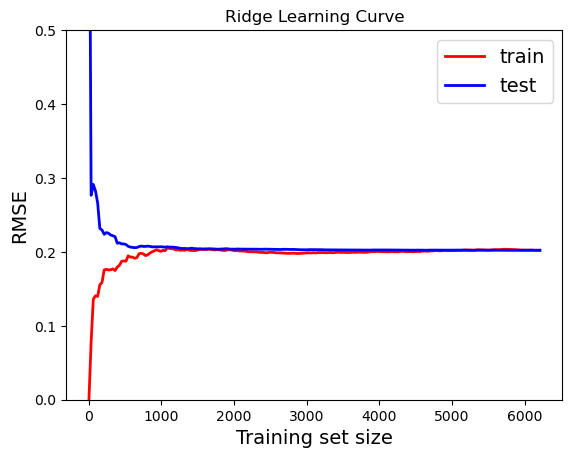

RMSE: [0.2019671  0.20360068 0.2054567  0.20028841 0.20735072] 0.20373272361499964
R2:  [0.80595727 0.80345043 0.80027815 0.80527439 0.79648477] 0.8022890027578405
--- Train ---
0.201603802669351 0.8065942460016472
--- Test ---
0.20908492580211405 0.7960121893539691


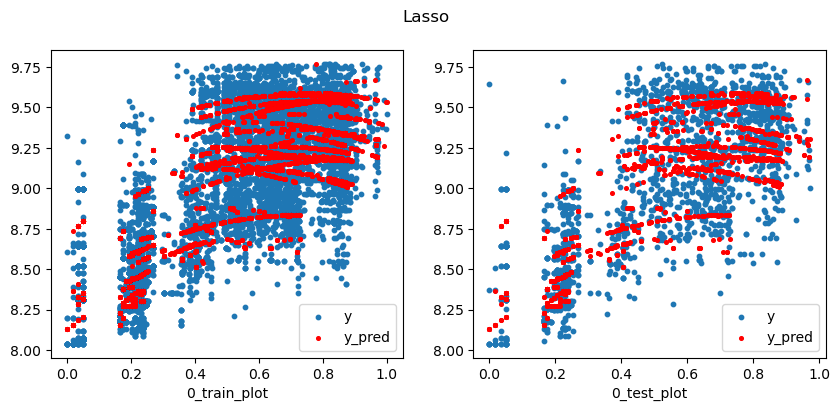

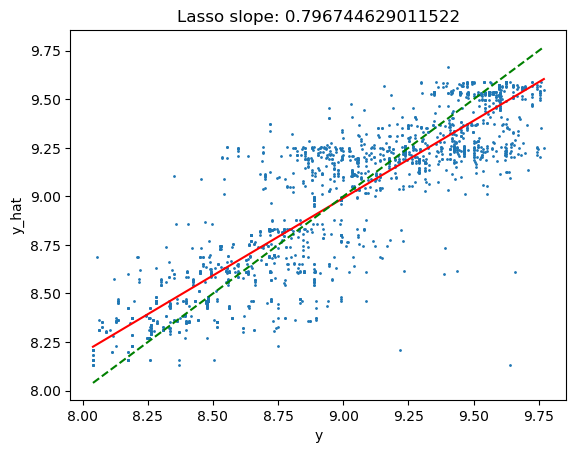

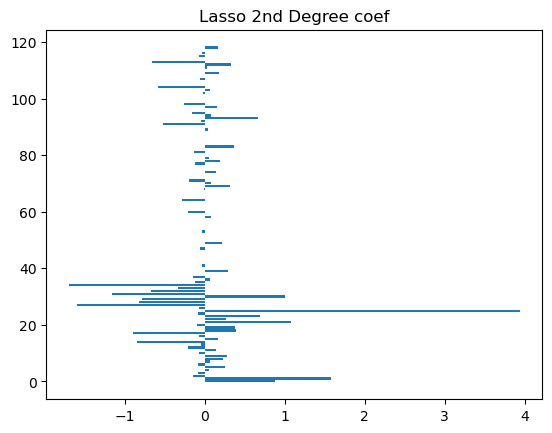

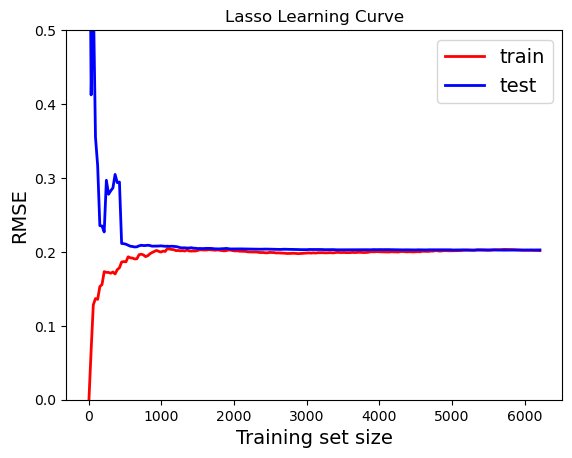

In [34]:
from sklearn.linear_model import Ridge, Lasso

ridge = Ridge(alpha=0.05, fit_intercept=True)
show_result(ridge, [Poly_X_train, Poly_X_test], [y_train, y_test], suptitle='Ridge')
ridge.fit(Poly_X_train, y_train)
plt.barh(Poly_X_train.columns, ridge.coef_)
plt.title('Ridge 2nd Degree coef')
plt.show()
plot_learning_curves(ridge, Poly_X_train, y_train, 'Ridge Learning Curve')

lasso = Lasso(alpha=1e-06, fit_intercept=True)
show_result(lasso, [Poly_X_train, Poly_X_test], [y_train, y_test], suptitle='Lasso')
lasso.fit(Poly_X_train, y_train)
plt.barh(Poly_X_train.columns, lasso.coef_)
plt.title('Lasso 2nd Degree coef')
plt.show()
plot_learning_curves(lasso, Poly_X_train, y_train, 'Lasso Learning Curve')

<h3>RandomForestRegressor</h3>

RMSE: [0.18545256 0.19128525 0.18432625 0.18215044 0.19517237] 0.18767737285399275
R2:  [0.83563118 0.82594529 0.83864361 0.83788334 0.82088477] 0.8317976386256865
--- Train ---
0.15794562123343467 0.8812900472303943
--- Test ---
0.20028176706548798 0.8128276902389894


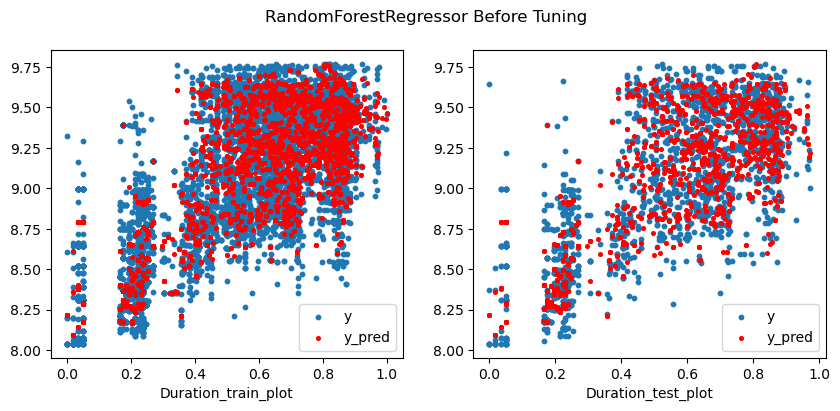

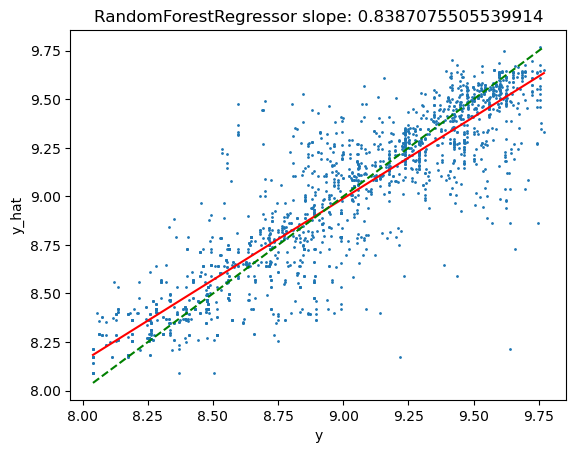

In [35]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor()
show_result(rfr, [X_train, X_test], [y_train, y_test], suptitle='RandomForestRegressor Before Tuning')

<h3>RandomForestRegressor 튜닝</h3>

In [36]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

rf = RandomForestRegressor()

param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [5, 7, 9, 12, 15, 20, 30],
    'min_samples_split': [3, 5, 10, 15, 30, 50],
    'min_samples_leaf': [1, 2, 5, 10, 30]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
grid_search.fit(X, y)

print(grid_search.best_params_)

{'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 15, 'n_estimators': 100}


<h3>RandomForestRegressor 튜닝 결과</h3>

RMSE: [0.18254133 0.18744598 0.18197486 0.1800347  0.19110826] 0.18462102662185645
R2:  [0.84082085 0.83306836 0.84440003 0.84239174 0.8276474 ] 0.8376656763661163
--- Train ---
0.16603113584637053 0.8688250131059635
--- Test ---
0.1949558217910152 0.8226500019330656


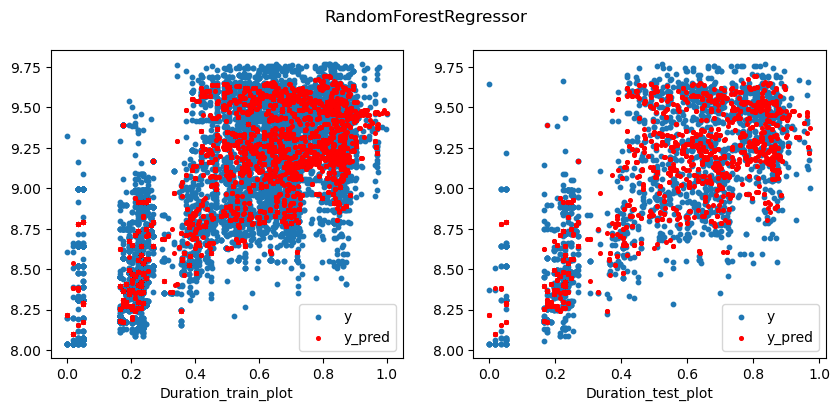

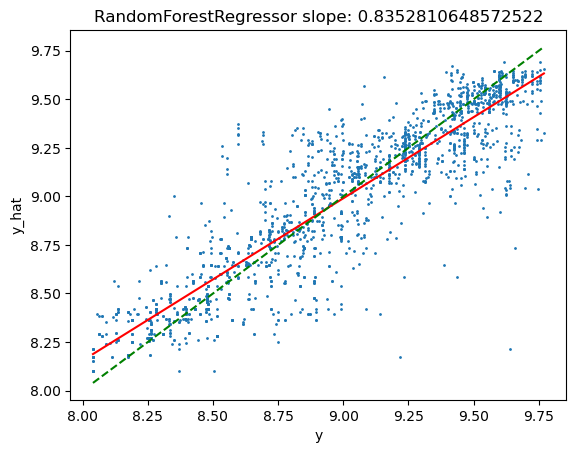

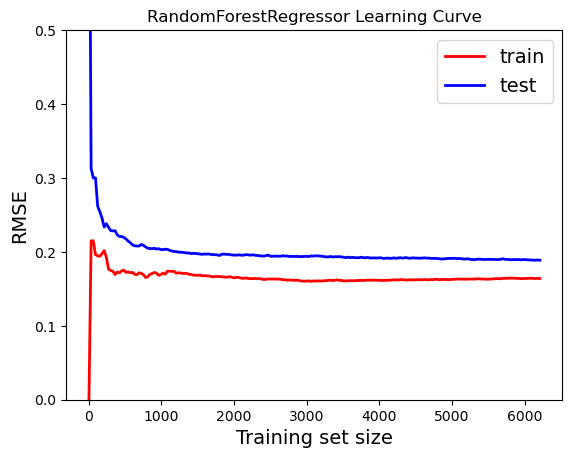

In [37]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(max_depth=20, min_samples_leaf=2, min_samples_split=15, n_estimators=100)
show_result(rfr, [X_train, X_test], [y_train, y_test], suptitle='RandomForestRegressor')
plot_learning_curves(rfr, X_train, y_train, 'RandomForestRegressor Learning Curve')

<h3>XGBRegressor</h3>

RMSE: [0.18525756 0.18780437 0.18402164 0.18164046 0.1936848 ] 0.18648176457051813
R2:  [0.83673693 0.83276582 0.83977778 0.83984644 0.82242701] 0.8343107975072224
--- Train ---
0.16493863425173655 0.8705456227758367
--- Test ---
0.19907962538430463 0.8150678578001722


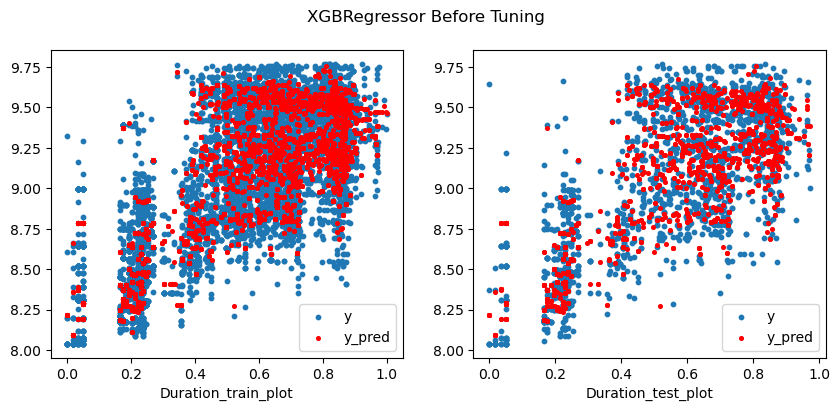

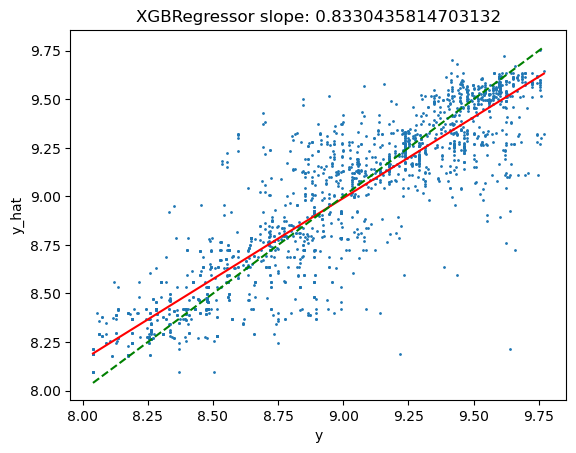

In [38]:
from xgboost import XGBRegressor

xgb = XGBRegressor()
show_result(xgb, [X_train, X_test], [y_train, y_test], suptitle='XGBRegressor Before Tuning')

<h3>XGBRegressor 튜닝</h3>

In [39]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

xgb = XGBRegressor()

param_grid = {
    'learning_rate':[0.001, 0.01, 0.05, 0.1],
    'n_estimators':[50,100,200,300,400],
    'max_depth':[5, 7, 9, 12, 15, 20, 30],
    'subsample':[0.5, 0.6, 0.7, 0.8, 0.9, 1],
    'colsample_bytree' : [0.1, 0.2, 0.3, 0.5, 0.7, 0.9, 1]
}

xgb_grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
xgb_grid_search.fit(X, y)

print(xgb_grid_search.best_params_)

{'colsample_bytree': 0.9, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.7}


<h3>XGBRegressor 튜닝 결과</h3>

RMSE: [0.18310267 0.18690216 0.18350652 0.18097077 0.19014946] 0.18492631732620618
R2:  [0.84051294 0.83436874 0.84067352 0.8410252  0.82885034] 0.8370861494940829
--- Train ---
0.16856267106647227 0.8647943748403993
--- Test ---
0.19617843646213956 0.8204186183690444


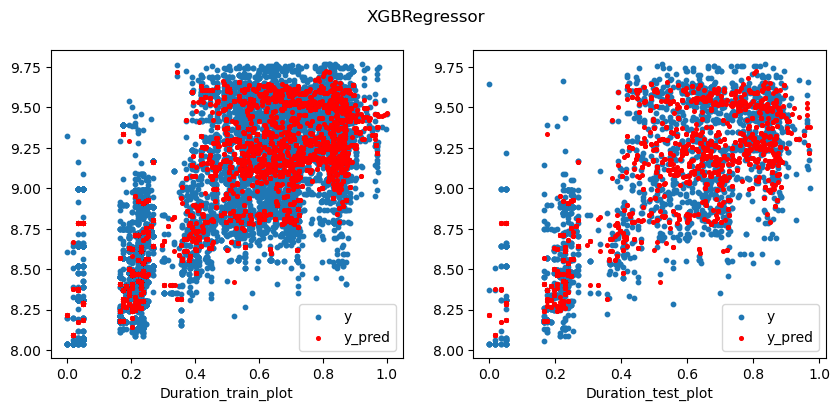

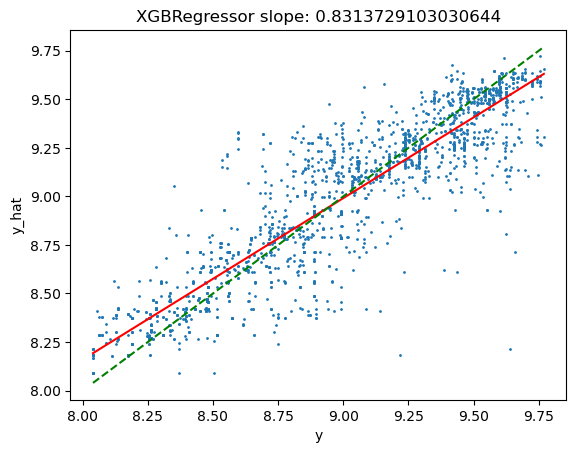

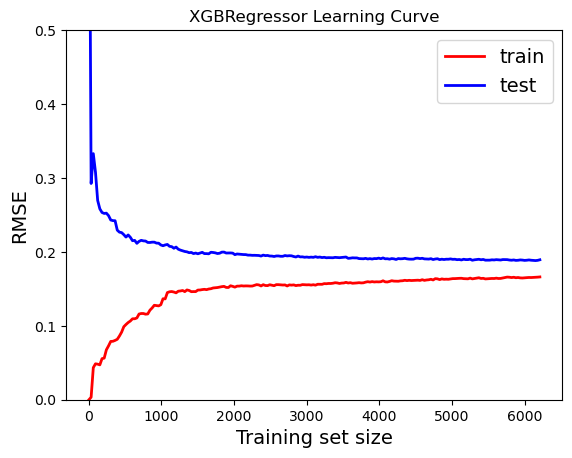

In [40]:
xgb = XGBRegressor(colsample_bytree=0.9, learning_rate=0.05, max_depth=7, n_estimators=300, subsample=0.7)
show_result(xgb, [X_train, X_test], [y_train, y_test], suptitle='XGBRegressor')
plot_learning_curves(xgb, X_train, y_train, 'XGBRegressor Learning Curve')

<h3>GradientBoostingRegressor</h3>

RMSE: [0.20026606 0.19971853 0.20449292 0.19699533 0.20503029] 0.20130062812942753
R2:  [0.8092121  0.81087438 0.80218744 0.811625   0.80101428] 0.8069826419084158
--- Train ---
0.19849730298600776 0.812508677644239
--- Test ---
0.20709414192589173 0.799878200647787


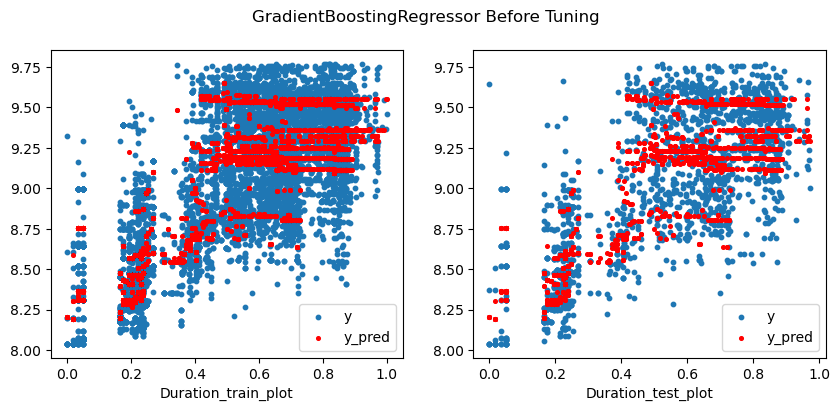

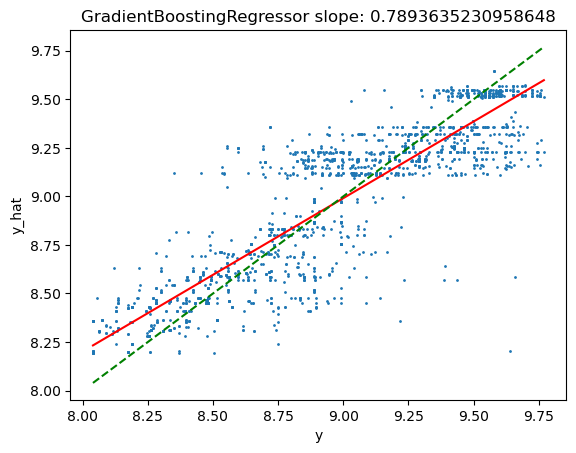

In [42]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor()
show_result(gbr, [X_train, X_test], [y_train, y_test], suptitle='GradientBoostingRegressor Before Tuning')

<h3>GradientBoostingRegressor 튜닝</h3>

In [46]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

gbr = GradientBoostingRegressor()

param_grid = {
    'n_estimators': [50, 100, 200, 300, 400, 500, 700, 900, 1200],
    'learning_rate':[0.05, 0.1, 0.2, 0.3, 0.35, 0.4, 0.5],
    'min_samples_split': [3, 5, 10, 15, 30, 50],
    'min_samples_leaf': [1, 2, 5, 10, 30]
}

gbr_grid_search = GridSearchCV(estimator=gbr, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

gbr_grid_search.fit(X, y)

print(gbr_grid_search.best_params_)

{'learning_rate': 0.35, 'min_samples_leaf': 5, 'min_samples_split': 15, 'n_estimators': 900}


<h3>GradientBoostingRegressor 튜닝 결과</h3>

RMSE: [0.18507436 0.18958789 0.18485894 0.18240252 0.19229756] 0.1868442535524872
R2:  [0.8371116  0.82957441 0.83846574 0.8384998  0.82497668] 0.8337256461425604
--- Train ---
0.1659851564386736 0.868897656264529
--- Test ---
0.19619982965541163 0.8203794496535715


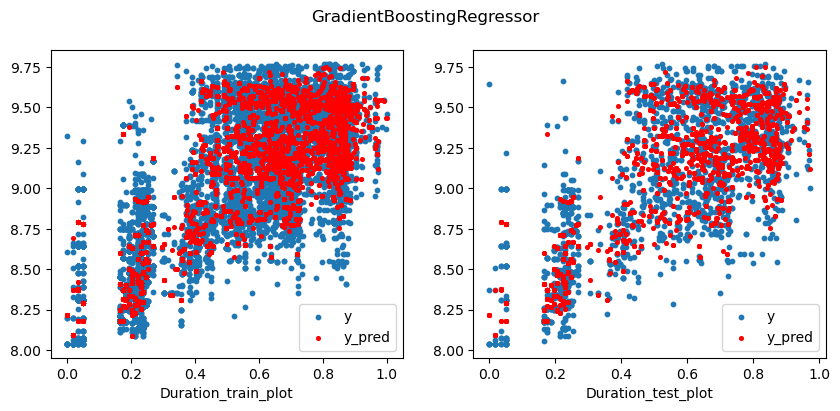

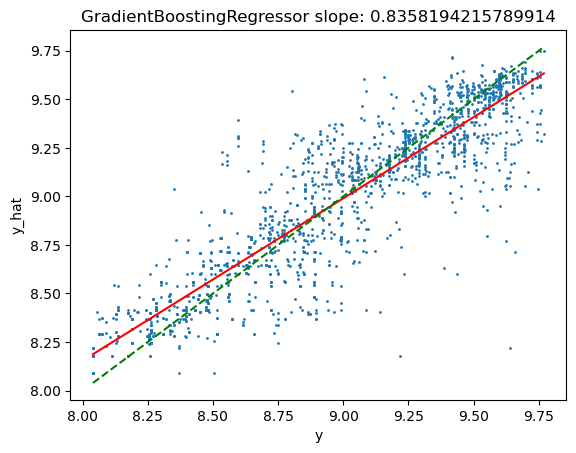

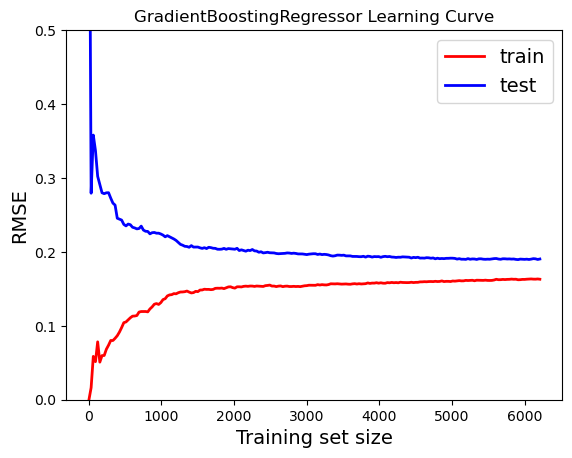

In [51]:
gbr = GradientBoostingRegressor(learning_rate=0.35, min_samples_leaf=5, min_samples_split=15, n_estimators=900)
show_result(gbr, [X_train, X_test], [y_train, y_test], suptitle='GradientBoostingRegressor')
plot_learning_curves(gbr, X_train, y_train, 'GradientBoostingRegressor Learning Curve')

<h3>SVR</h3>

RMSE: [0.1999252  0.20320929 0.21022297 0.19925308 0.20633138] 0.20378838456041634
R2:  [0.80986101 0.80420537 0.7909042  0.80728235 0.79848082] 0.8021467509993894
--- Train ---
0.20131247700637198 0.8071528004439508
--- Test ---
0.20916547104531047 0.7958549956926336


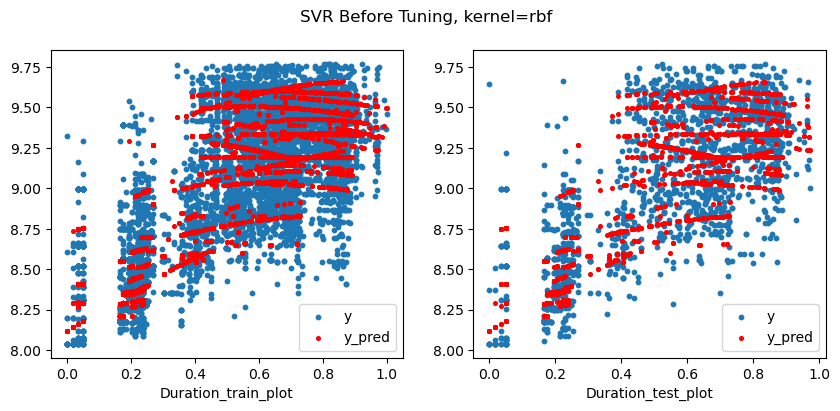

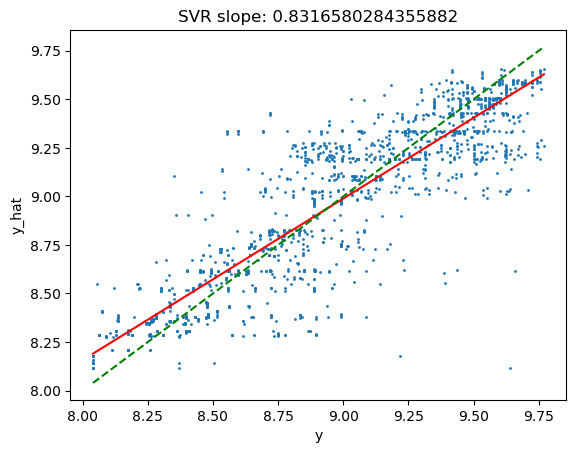

RMSE: [0.22389469 0.22102373 0.22577528 0.21798337 0.22569517] 0.22287444878906598
R2:  [0.76153552 0.76837179 0.75882197 0.76934752 0.75888159] 0.7633916787517713
--- Train ---
0.22224011913637354 0.7649734779417763
--- Test ---
0.2265967390748549 0.760411437328092


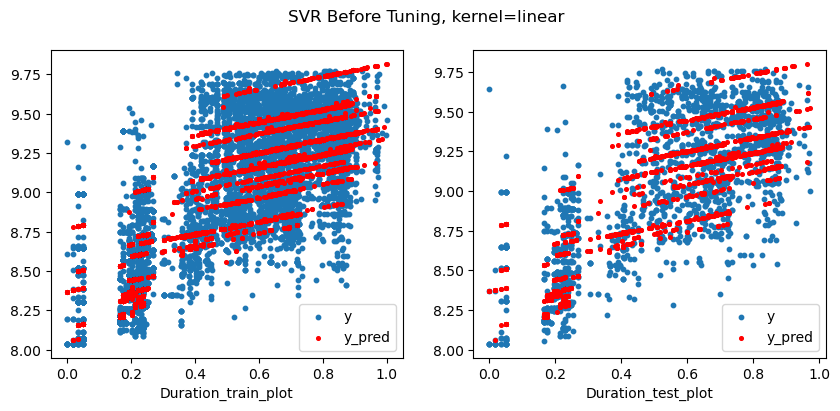

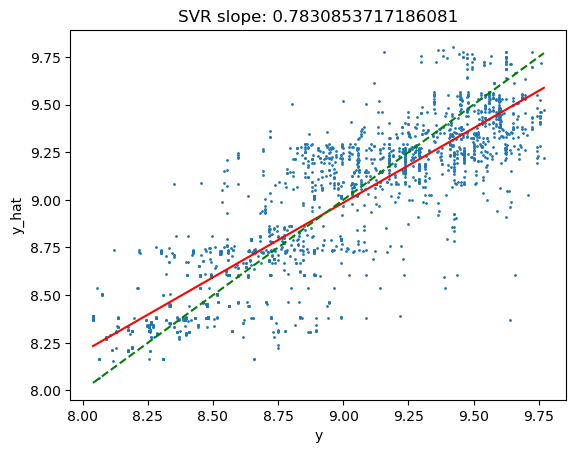

RMSE: [0.20832613 0.20987795 0.21408986 0.20258465 0.21283363] 0.20954244022421906
R2:  [0.79354587 0.79114385 0.78314115 0.80078389 0.78557949] 0.7908388519136265
--- Train ---
0.20597700157535895 0.7981125070018259
--- Test ---
0.21213001594290692 0.7900272095064864


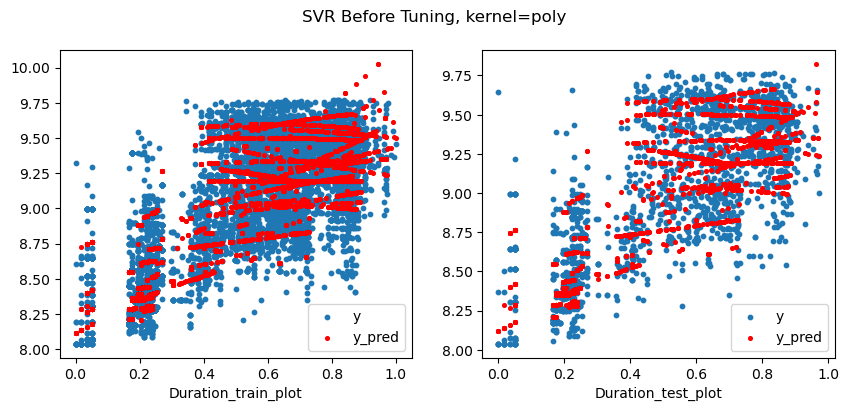

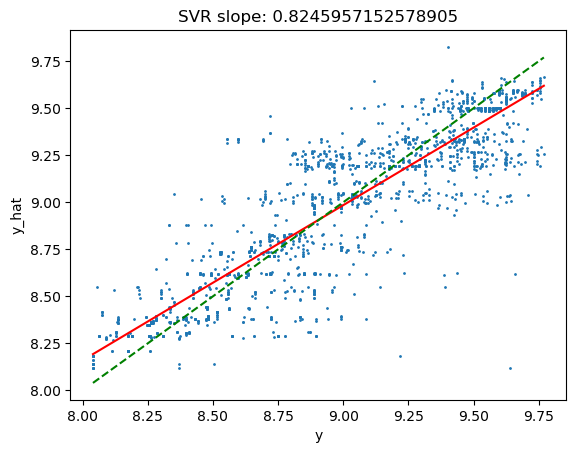

RMSE: [105.54316173 105.79669935 106.81789232 110.39064864 103.11566752] 106.3328139115049
R2:  [-52989.29032943 -53070.07359165 -53983.9842416  -59151.8910262
 -50329.9522445 ] -53905.0382866743
--- Train ---
132.00569323031678 -82918.61477573651
--- Test ---
134.6552847141667 -84605.85967100225


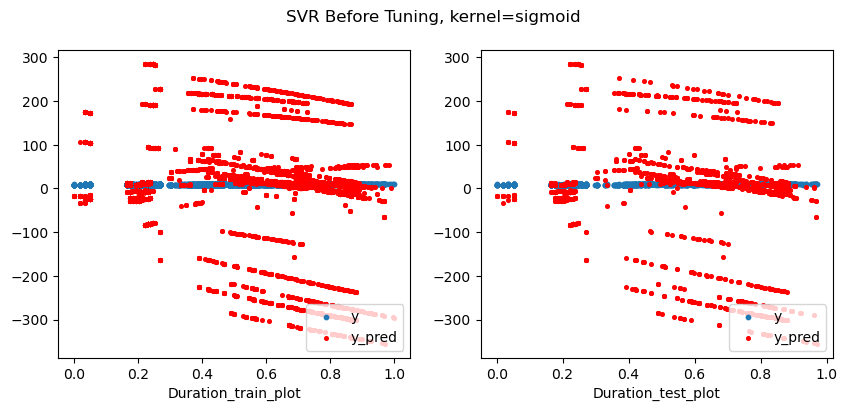

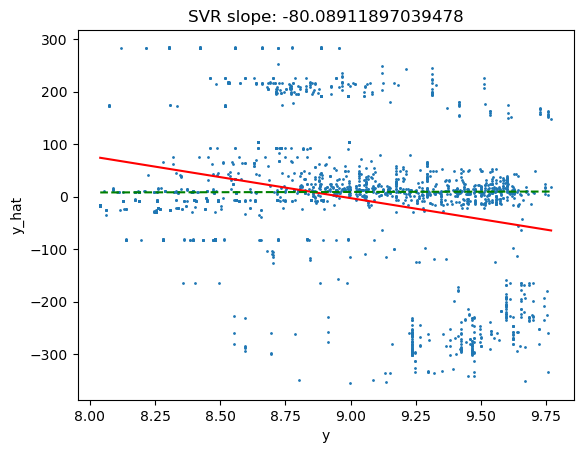

In [52]:
from sklearn.svm import SVR

for kernel in ['rbf', 'linear', 'poly', 'sigmoid']:
    svr = SVR(kernel=kernel).fit(X_train, y_train)
    show_result(svr, [X_train, X_test], [y_train, y_test], suptitle='SVR Before Tuning, kernel=' + kernel)

<h3>SVR 파라미터 튜닝</h3>

In [60]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

svr = SVR()

param_grid = {
    'C': [0.1, 1, 5, 10, 100],
    'gamma': [0.01, 0.1, 1, 5],
    'kernel': ['rbf', 'poly']
}

svr_grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')

svr_grid_search.fit(X_train, y_train)

print(svr_grid_search.best_params_)

{'C': 100, 'gamma': 5, 'kernel': 'rbf'}


<h3>SVR 튜닝 결과</h3>

RMSE: [0.19416234 0.20022617 0.19435744 0.19281207 0.20294768] 0.19690114135000775
R2:  [0.82066457 0.80991173 0.82127417 0.81954047 0.80503618] 0.8152854226852562
--- Train ---
0.1923194984233894 0.8239976012742618
--- Test ---
0.2092164184064341 0.7957555345734519


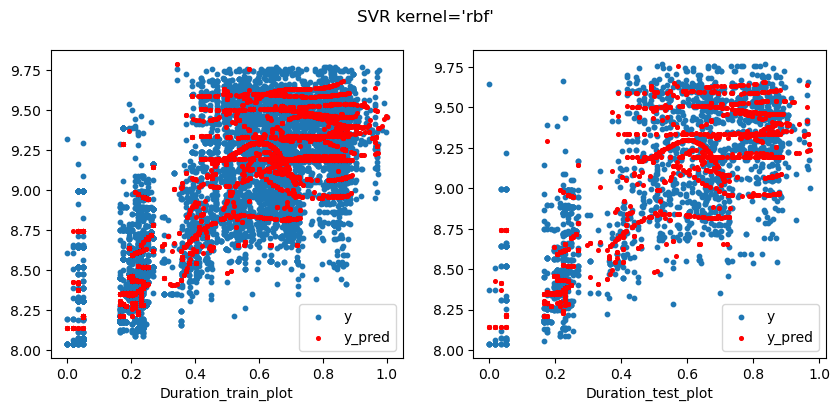

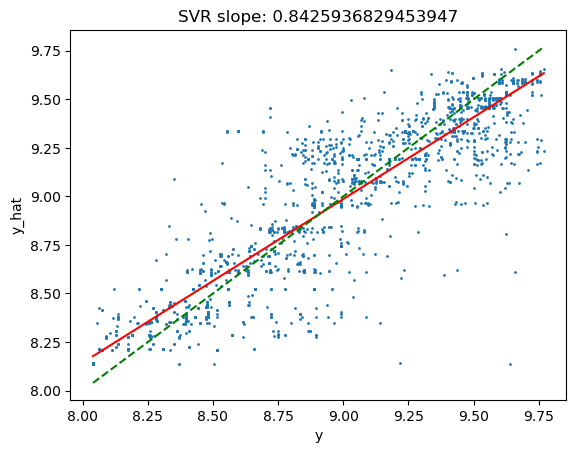

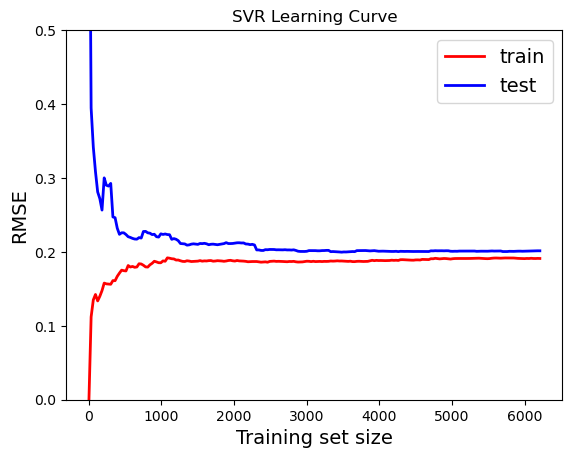

In [63]:
from sklearn.svm import SVR
svr = SVR(C=100, gamma=5, kernel='rbf')
show_result(svr, [X_train, X_test], [y_train, y_test], suptitle="SVR kernel='rbf'")
plot_learning_curves(svr, X_train, y_train, 'SVR Learning Curve')

<h3>CV 기반 Stacking 및 결과</h3>

In [68]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR

from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, accuracy_score
from mlxtend.regressor import StackingCVRegressor

def get_data_sets(model, X_train, y_train, X_test, n_folds):
    kfold = KFold(n_splits=n_folds, shuffle=False)
    y_hat_train = np.zeros((X_train.shape[0], 1))
    y_hat_test=np.zeros((X_test.shape[0], n_folds))
    
    for index_fold, (index_train, index_valid) in enumerate(kfold.split(X_train)):
        _X_train = X_train.iloc[index_train]
        _y_train = y_train.iloc[index_train]
        _X_valid = X_train.iloc[index_valid]
        
        model.fit(_X_train, _y_train)
        
        y_hat_train[index_valid, :] = model.predict(_X_valid).reshape(-1, 1)
        y_hat_test[:, index_fold] = model.predict(X_test)
        
    y_hat = np.mean(y_hat_test, axis=1).reshape(-1, 1)
    return y_hat_train, y_hat

lr = LinearRegression(fit_intercept=True, positive=True)
rfr = RandomForestRegressor(n_estimators=100, max_depth=20, min_samples_split=15, min_samples_leaf=2)
gbr = GradientBoostingRegressor(learning_rate=0.35, n_estimators=900, min_samples_split=15, min_samples_leaf=5)
svr = SVR(C=100, gamma=5, kernel='rbf')

X_lr_train, X_lr_test = get_data_sets(lr, Poly_X_train, y_train, Poly_X_test, 5)
X_rfr_train, X_rfr_test = get_data_sets(rfr, X_train, y_train, X_test, 5)
X_gbr_train, X_gbr_test = get_data_sets(gbr, X_train, y_train, X_test, 5)
X_svr_train, X_svr_test = get_data_sets(svr, X_train, y_train, X_test, 5)

X_train_new = np.concatenate((X_lr_train, X_rfr_train, X_gbr_train, X_svr_train), axis=1)
X_test_new = np.concatenate((X_lr_test, X_rfr_test, X_gbr_test, X_svr_test), axis=1)


rfr_meta = RandomForestRegressor()
rfr_meta.fit(X_train_new, y_train)

pred = rfr_meta.predict(X_test_new)
mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, pred)
print('RMSE:', rmse, 'R2:', r2)

neg_mse_scores = cross_val_score(rfr_meta, X_train_new, y_train, scoring='neg_mean_squared_error', cv=5)
rmse_scores = np.sqrt(-1*neg_mse_scores)
avg_rmse=np.mean(rmse_scores)
print('RMSE:', rmse_scores, avg_rmse)

r2_scores = cross_val_score(rfr_meta, X_train_new, y_train, scoring='r2', cv=5)
print('R2', r2_scores, np.mean(r2_scores))

RMSE: 0.1975923238497965 R2: 0.8178207505186921
RMSE: [0.17990071 0.18515236 0.17773395 0.18057002 0.1941141 ] 0.1834942261155768
R2 [0.84350314 0.83844853 0.85060086 0.8433228  0.82149149] 0.8394733645817867
